In [24]:
import pandas as pd
import os
import traceback

# Define file paths
bed_file = "/Users/yashtandi/Desktop/Genome-Wide-Enhancer-Prediction/data/bed_files /merged_bed_data.bed"
bedpe_file = "/Users/yashtandi/Desktop/Genome-Wide-Enhancer-Prediction/data/bedpe_files/ENCFF483VSI.bedpe"

# Define output paths for subsetted data
bed_subset_file = "/Users/yashtandi/Desktop/Genome-Wide-Enhancer-Prediction/data/bed_files/merged_bed_data_subset.bed"
bedpe_subset_file = "/Users/yashtandi/Desktop/Genome-Wide-Enhancer-Prediction/data/bedpe_files/ENCFF483VSI_subset.bedpe"

def validate_file_exists(file_path):
    """Check if input file exists before processing."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Input file not found: {file_path}")

def create_subset(input_file, output_file, num_lines=10000):
    """Create a subset of a large file by reading in chunks."""
    try:
        # Validate input file exists
        validate_file_exists(input_file)
        
        # Ensure output directory exists
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        
        chunk_size = 1000  # Lines per chunk
        total_lines = 0
        chunks = []

        # Read file in chunks
        for chunk in pd.read_csv(
            input_file,
            sep="\t",
            header=None,
            chunksize=chunk_size,
            comment='#',  # Skip comment lines
            on_bad_lines='warn',  # Warn about bad lines but skip them
            encoding='utf-8'
        ):
            chunks.append(chunk)
            total_lines += len(chunk)
            if total_lines >= num_lines:
                break  # Stop once we have enough lines

        # Combine chunks and truncate to exact num_lines
        if chunks:
            subset_df = pd.concat(chunks, ignore_index=True).head(num_lines)
            subset_df.to_csv(output_file, sep="\t", index=False, header=False, encoding="utf-8")
            print(f"✅ Subset created: {output_file} ({len(subset_df)} rows)")
        else:
            print(f"⚠️ No data read from {input_file}. Check file format or content.")

    except Exception as e:
        print(f"❌ Critical error processing {input_file}:")
        traceback.print_exc()  # Show full error details

# Create subsets for each file
create_subset(bed_file, bed_subset_file)
create_subset(bedpe_file, bedpe_subset_file)

print("\nVerification:")
for path in [bed_subset_file, bedpe_subset_file, biginteract_subset_file]:
    if os.path.exists(path):
        line_count = sum(1 for _ in open(path))
        print(f"  - {os.path.basename(path)}: {line_count} lines")
    else:
        print(f"  - {os.path.basename(path)}: Does not exist")

✅ Subset created: /Users/yashtandi/Desktop/Genome-Wide-Enhancer-Prediction/data/bed_files/merged_bed_data_subset.bed (10000 rows)
✅ Subset created: /Users/yashtandi/Desktop/Genome-Wide-Enhancer-Prediction/data/bedpe_files/ENCFF483VSI_subset.bedpe (10000 rows)

Verification:
  - merged_bed_data_subset.bed: 10000 lines
  - ENCFF483VSI_subset.bedpe: 10000 lines
  - ENCFF979EBY_subset.bigInteract: Does not exist


In [9]:
import pandas as pd
import os

# Define file paths
bed_file = "/Users/yashtandi/Desktop/Genome-Wide-Enhancer-Prediction/data/bed_files/merged_bed_data_subset.bed"
bedpe_file = "/Users/yashtandi/Desktop/Genome-Wide-Enhancer-Prediction/data/bedpe_files/ENCFF483VSI_subset.bedpe"

# Output file for the final testing set
output_file = "/Users/yashtandi/Documents/Genome-Wide-Enhancer-Prediction/data/testing_subset.bed"

# Ensure the output directory exists
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Function to safely read large tab-separated files line by line
def safe_read_tsv(file_path):
    if not os.path.exists(file_path):
        print(f"⚠️ Warning: {file_path} not found. Skipping...")
        return pd.DataFrame()  # Return empty DataFrame

    valid_rows = []
    
    with open(file_path, "r", encoding="utf-8", errors="replace") as f:
        for line in f:
            cols = line.strip().split("\t")  # Split line into columns using tab
            if len(cols) >= 3:  # Ensure at least 3 columns (modify as per file structure)
                valid_rows.append(cols)
            else:
                print(f"❌ Skipping malformed row in {file_path}: {line.strip()}")

    if not valid_rows:
        print(f"⚠️ No valid data found in {file_path}. Skipping...")
        return pd.DataFrame()
    
    return pd.DataFrame(valid_rows)

# Load datasets
bed_data = safe_read_tsv(bed_file)
bedpe_data = safe_read_tsv(bedpe_file)

# Debugging: Print shapes
print(f"📊 BED Data Shape: {bed_data.shape}")
print(f"📊 BEDPE Data Shape: {bedpe_data.shape}")

# Define the fraction for the testing subset
subset_fraction = 0.005  # **Reduced to 0.5% to prevent data overflow**

# Sample only if data is loaded
bed_subset = bed_data.sample(frac=subset_fraction, random_state=42) if not bed_data.empty else pd.DataFrame()
bedpe_subset = bedpe_data.sample(frac=subset_fraction, random_state=42) if not bedpe_data.empty else pd.DataFrame()

# Merge all subsets
final_testing_set = pd.concat([bed_subset, bedpe_subset], ignore_index=True)

# Shuffle the final dataset
final_testing_set = final_testing_set.sample(frac=1, random_state=42)

# Save the final testing set as a `.bed` file (tab-separated)
final_testing_set.to_csv(output_file, sep="\t", index=False, header=False, encoding="utf-8")

# Display final dataset info
print(f"✅ Final testing data saved to {output_file}")
print(f"📊 Shape of the final testing dataset: {final_testing_set.shape}")


📊 BED Data Shape: (10000, 27)
📊 BEDPE Data Shape: (10000, 10)
✅ Final testing data saved to /Users/yashtandi/Documents/Genome-Wide-Enhancer-Prediction/data/testing_subset.bed
📊 Shape of the final testing dataset: (100, 27)


In [13]:
# Step 1: Data Cleaning

# 1. Remove Duplicates
print(f"Original data shape: {final_testing_set.shape}")
final_testing_set = final_testing_set.drop_duplicates()
print(f"Data shape after removing duplicates: {final_testing_set.shape}")

# 2. Handle Missing Values
print("Missing values per column before handling:")
print(final_testing_set.isnull().sum())

# Fill missing values with 0 (you can modify this strategy as needed)
final_testing_set = final_testing_set.fillna(0)

print("Missing values per column after handling:")
print(final_testing_set.isnull().sum())

# 3. Validate Data Consistency
print("Data types of each column:")
print(final_testing_set.dtypes)

# Ensure numerical columns contain only numeric values
numerical_columns = final_testing_set.select_dtypes(include=['number']).columns
print(f"Numerical columns identified: {list(numerical_columns)}")

# Convert numeric columns to appropriate types if needed
for col in numerical_columns:
    final_testing_set[col] = pd.to_numeric(final_testing_set[col], errors='coerce')

# Drop any rows that became NaN after type conversion (optional)
final_testing_set = final_testing_set.dropna()

# Display a sample of the cleaned data
print("Cleaned data preview:")
print(final_testing_set.head())

# Final check of the data shape
print(f"Final data shape after cleaning: {final_testing_set.shape}")



Original data shape: (100, 27)
Data shape after removing duplicates: (100, 27)
Missing values per column before handling:
0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10    50
11    50
12    50
13    50
14    50
15    50
16    50
17    50
18    50
19    50
20    50
21    50
22    50
23    50
24    50
25    50
26    52
dtype: int64
Missing values per column after handling:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
dtype: int64
Data types of each column:
0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
13    object
14    object
15    object
16    object
17    object
18    object
19    object
20    object
21    object
22    object
23    object
24    object

In [19]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd

# Step 1: Ensure Column Names Exist
if final_testing_set.columns is None or not all(isinstance(col, str) for col in final_testing_set.columns):
    final_testing_set.columns = [f"col_{i}" for i in range(final_testing_set.shape[1])]

# Step 2: Standardize Column Names
final_testing_set.columns = [str(col).strip().lower().replace(" ", "_") for col in final_testing_set.columns]

# Step 3: Data Cleaning (Remove duplicates and handle missing values)
final_testing_set = final_testing_set.drop_duplicates().fillna(0)

# Step 4: Convert Data Types
numerical_columns = final_testing_set.select_dtypes(include=['number']).columns.tolist()
categorical_columns = final_testing_set.select_dtypes(exclude=['number']).columns.tolist()

# Convert numeric columns to proper format
for col in numerical_columns:
    final_testing_set[col] = pd.to_numeric(final_testing_set[col], errors='coerce')

# Drop any remaining NaN values after conversion (optional)
final_testing_set = final_testing_set.dropna()

# Step 5: Encode Categorical Features
if categorical_columns:
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        final_testing_set[col] = le.fit_transform(final_testing_set[col].astype(str))
        label_encoders[col] = le  # Store encoders for later use

# Recalculate numerical columns after encoding
numerical_columns = final_testing_set.select_dtypes(include=['number']).columns.tolist()

# Step 6: Feature Scaling (Normalization) - Only if numerical columns exist
if numerical_columns:
    scaler = MinMaxScaler()
    final_testing_set[numerical_columns] = scaler.fit_transform(final_testing_set[numerical_columns])

# Step 7: Final Data Checks
print("Processed Data Preview:")
print(final_testing_set.head())

print(f"✅ Final shape after preprocessing: {final_testing_set.shape}")
print(f"📊 Numerical columns scaled: {numerical_columns}")


Processed Data Preview:
    col_0     col_1     col_2     col_3  col_4     col_5     col_6     col_7  \
83   0.25  0.428571  0.428571  0.018519   0.40  0.551020  0.555556  0.428571   
53   0.00  0.959184  0.959184  0.000000   0.92  0.979592  0.909091  0.122449   
70   1.00  0.020408  0.020408  0.074074   0.02  0.183673  0.525253  0.377551   
45   0.50  0.000000  0.000000  0.814815   1.00  0.122449  0.121212  0.653061   
44   1.00  0.530612  0.530612  1.000000   1.00  0.061224  0.060606  0.591837   

       col_8  col_9  ...  col_17  col_18  col_19  col_20  col_21  col_22  \
83  0.000000    1.0  ...     0.0     0.0     0.0     0.0    0.00     0.0   
53  0.000000    1.0  ...     0.0     0.0     0.0     0.0    0.00     0.0   
70  0.000000    1.0  ...     0.0     0.0     0.0     0.0    0.00     0.0   
45  0.020408    0.0  ...     1.0     1.0     1.0     1.0    0.94     1.0   
44  0.530612    0.0  ...     0.4     0.4     1.0     0.4    0.04     0.1   

    col_23  col_24  col_25    col_26  

Dataset Preview:
    col_0     col_1     col_2     col_3  col_4     col_5     col_6     col_7  \
83   0.25  0.428571  0.428571  0.018519   0.40  0.551020  0.555556  0.428571   
53   0.00  0.959184  0.959184  0.000000   0.92  0.979592  0.909091  0.122449   
70   1.00  0.020408  0.020408  0.074074   0.02  0.183673  0.525253  0.377551   
45   0.50  0.000000  0.000000  0.814815   1.00  0.122449  0.121212  0.653061   
44   1.00  0.530612  0.530612  1.000000   1.00  0.061224  0.060606  0.591837   

       col_8  col_9  ...  col_17  col_18  col_19  col_20  col_21  col_22  \
83  0.000000    1.0  ...     0.0     0.0     0.0     0.0    0.00     0.0   
53  0.000000    1.0  ...     0.0     0.0     0.0     0.0    0.00     0.0   
70  0.000000    1.0  ...     0.0     0.0     0.0     0.0    0.00     0.0   
45  0.020408    0.0  ...     1.0     1.0     1.0     1.0    0.94     1.0   
44  0.530612    0.0  ...     0.4     0.4     1.0     0.4    0.04     0.1   

    col_23  col_24  col_25    col_26  
83    

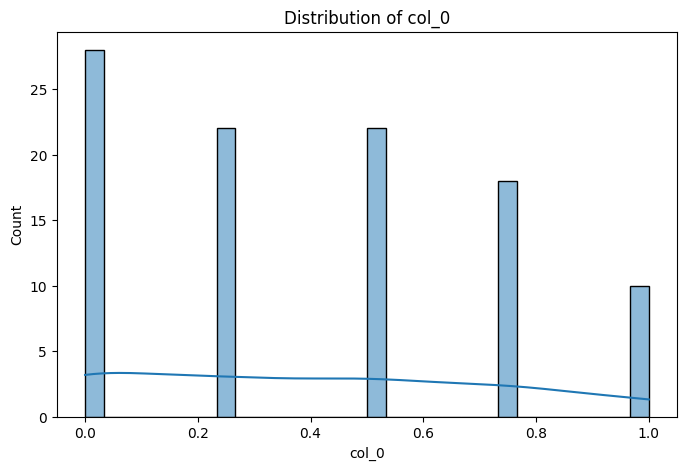

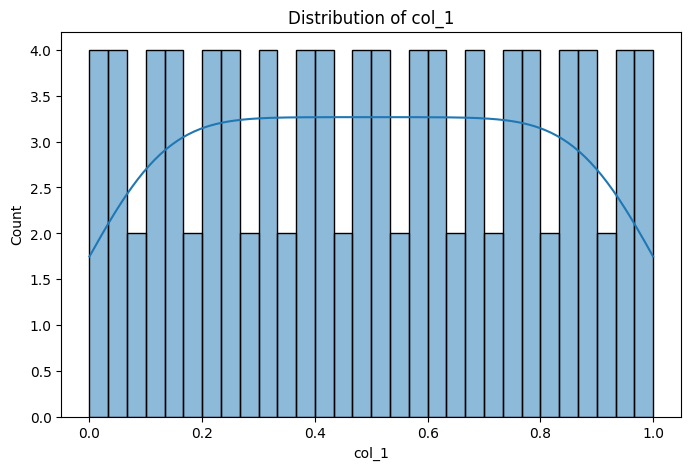

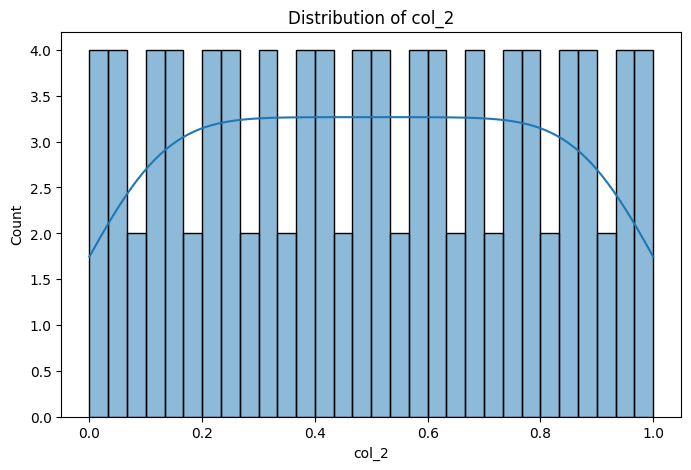

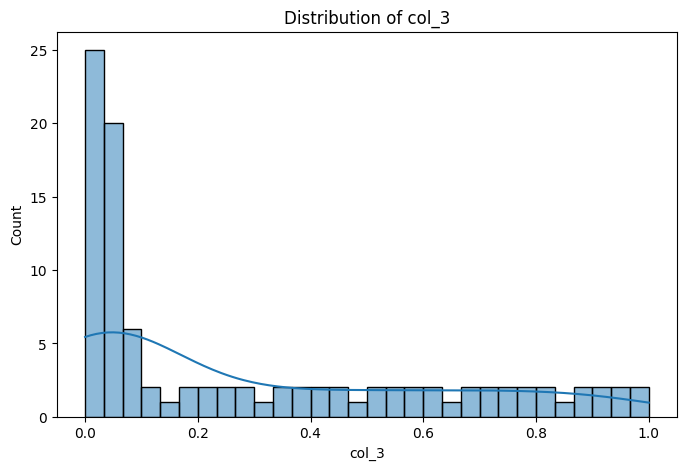

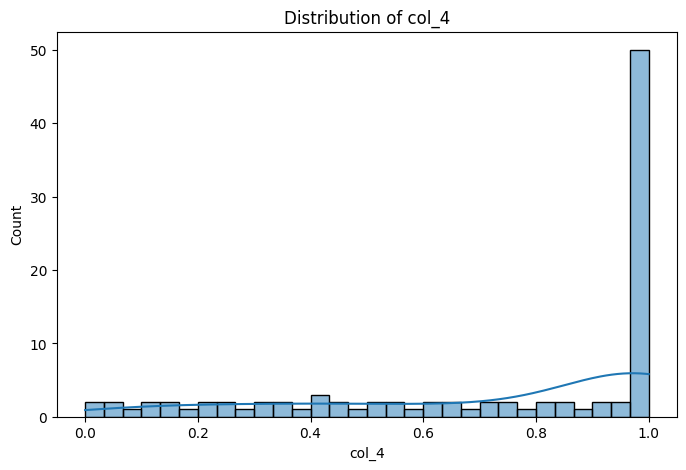

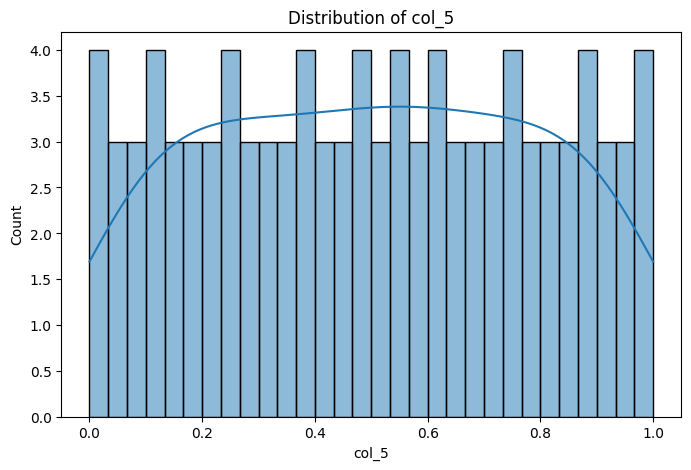

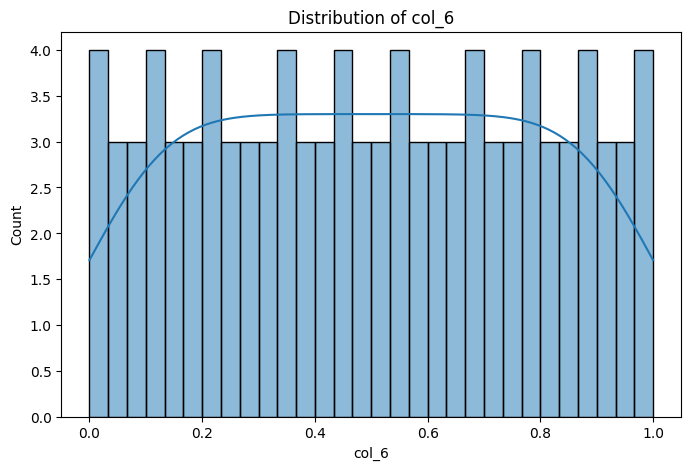

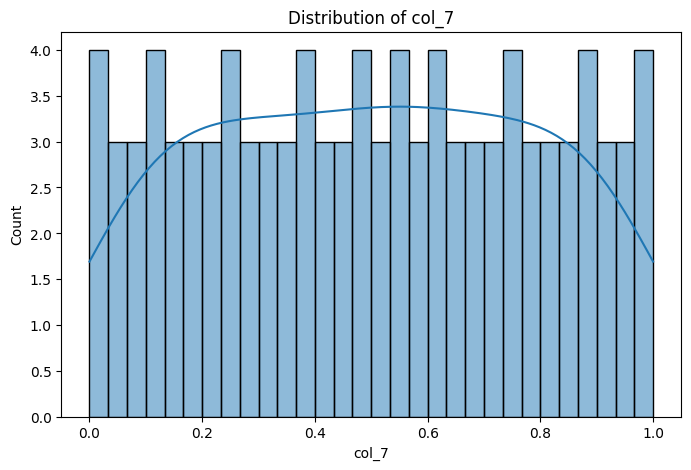

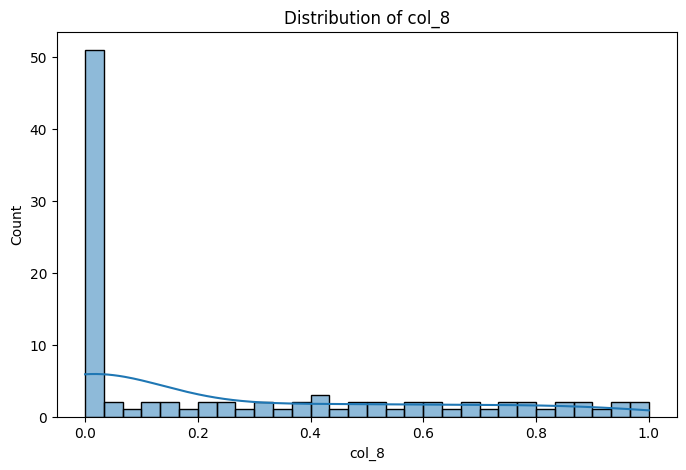

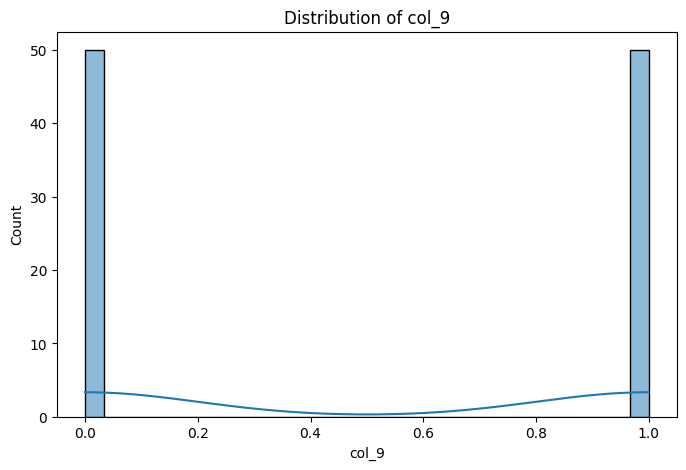

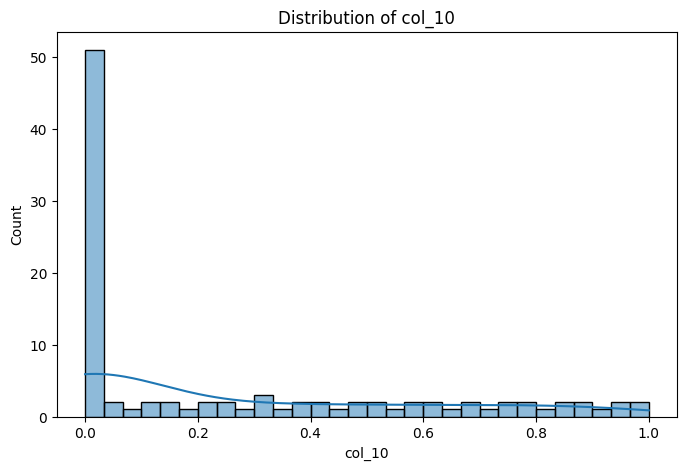

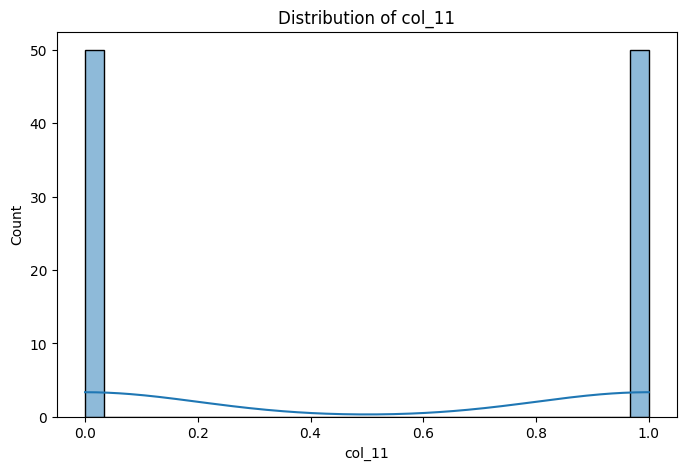

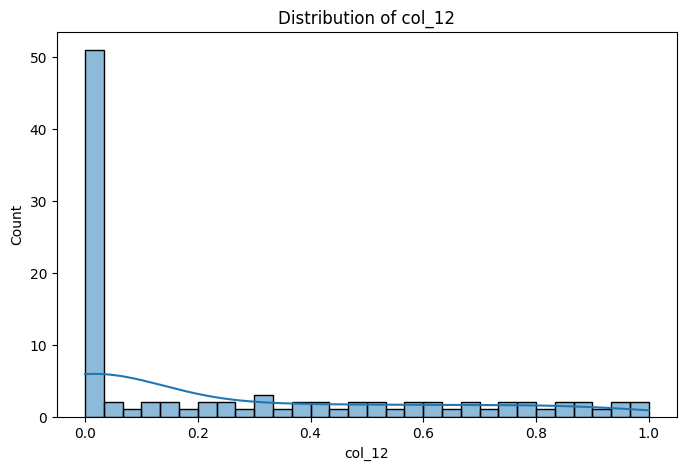

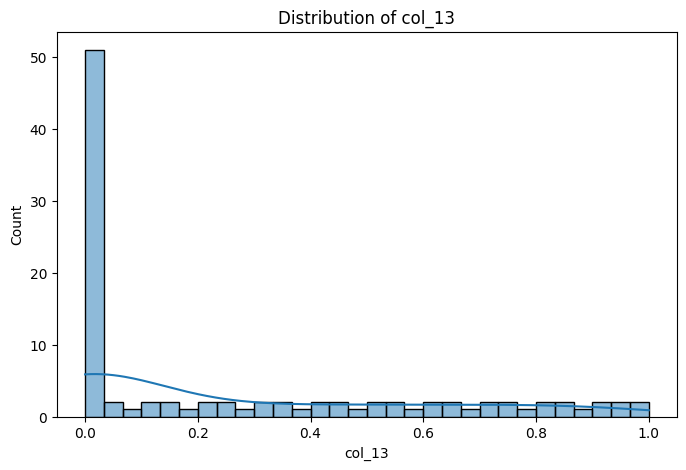

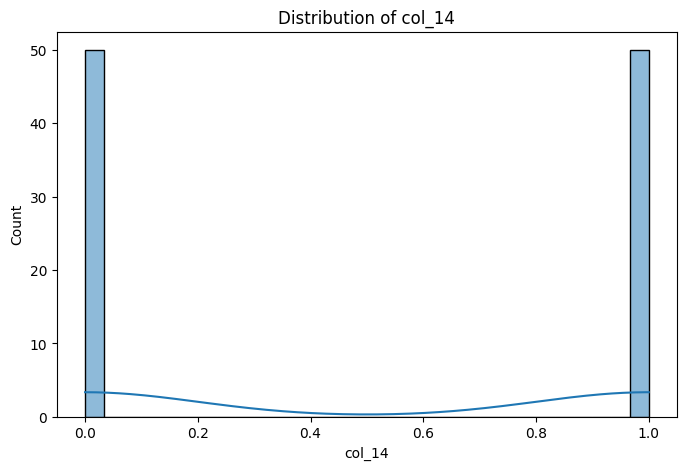

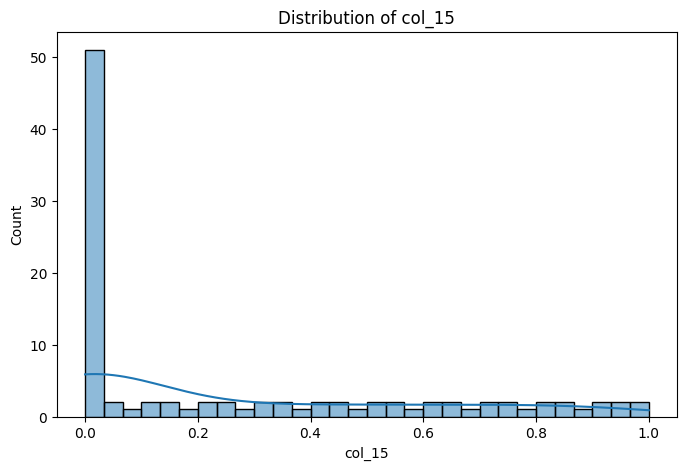

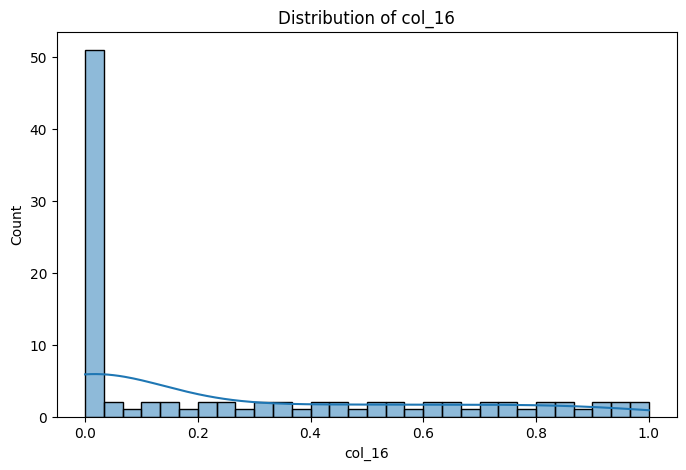

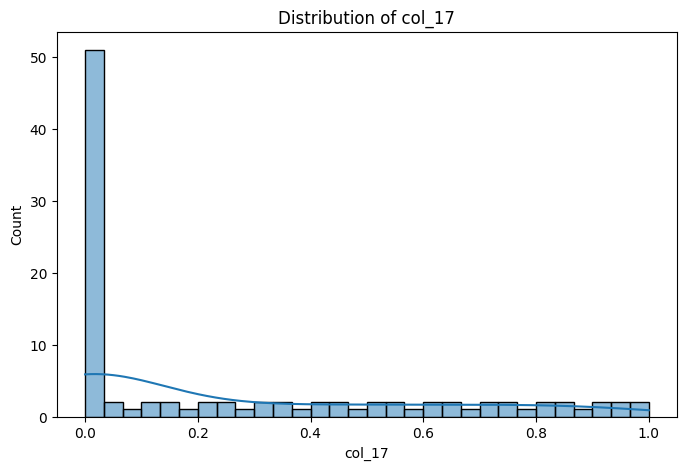

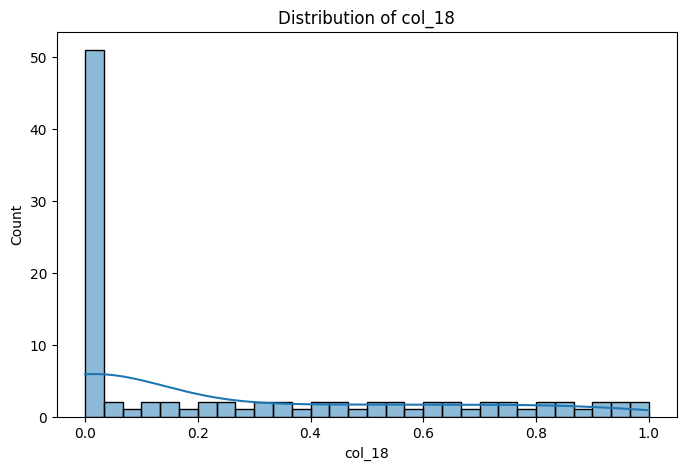

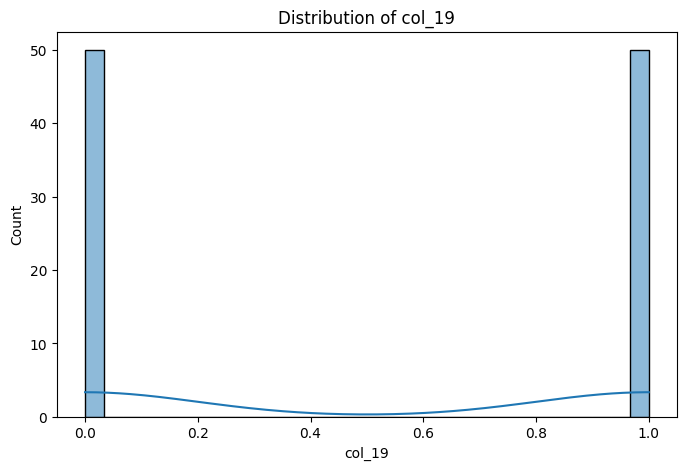

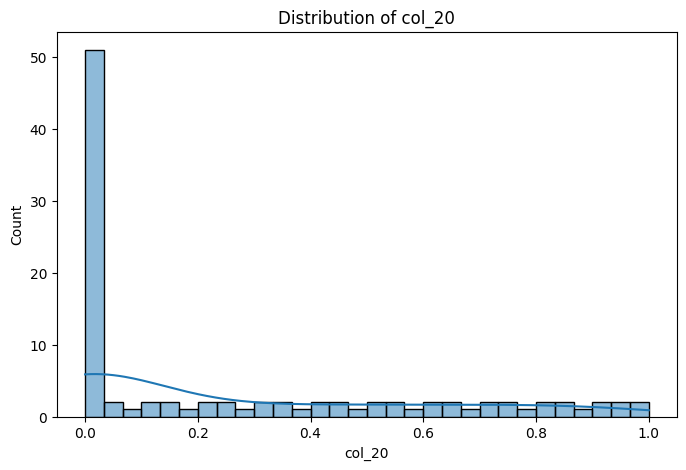

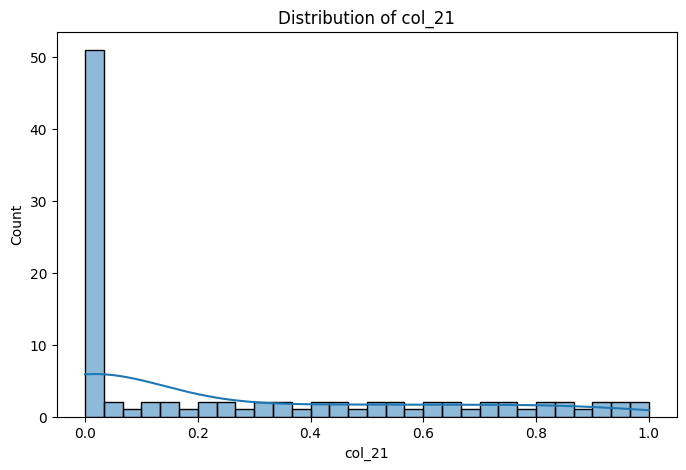

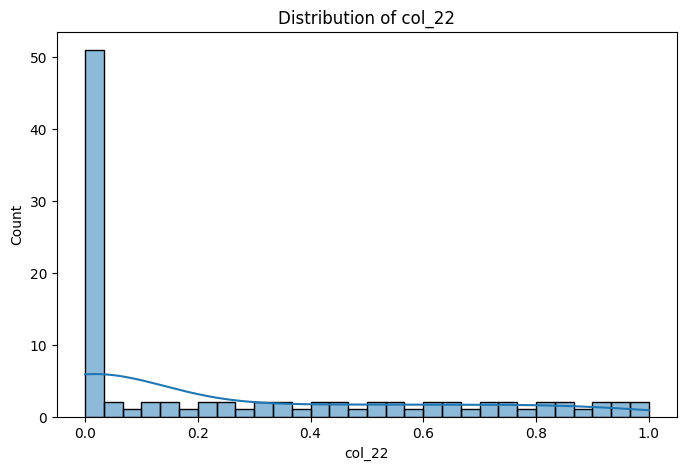

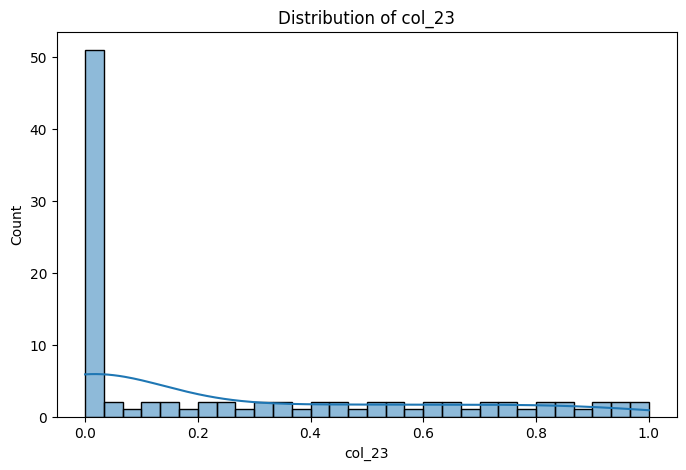

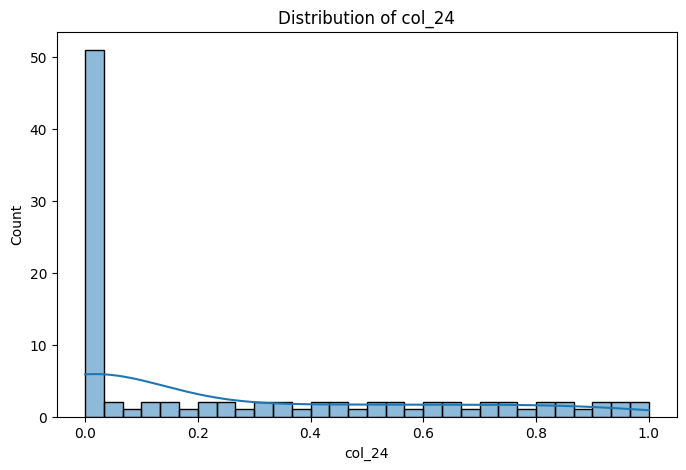

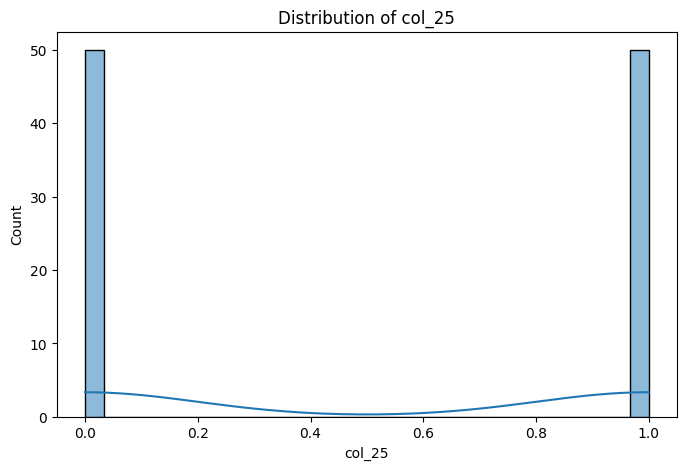

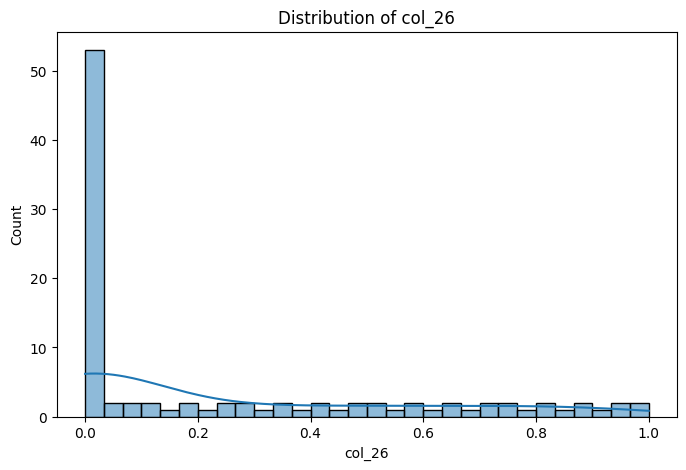

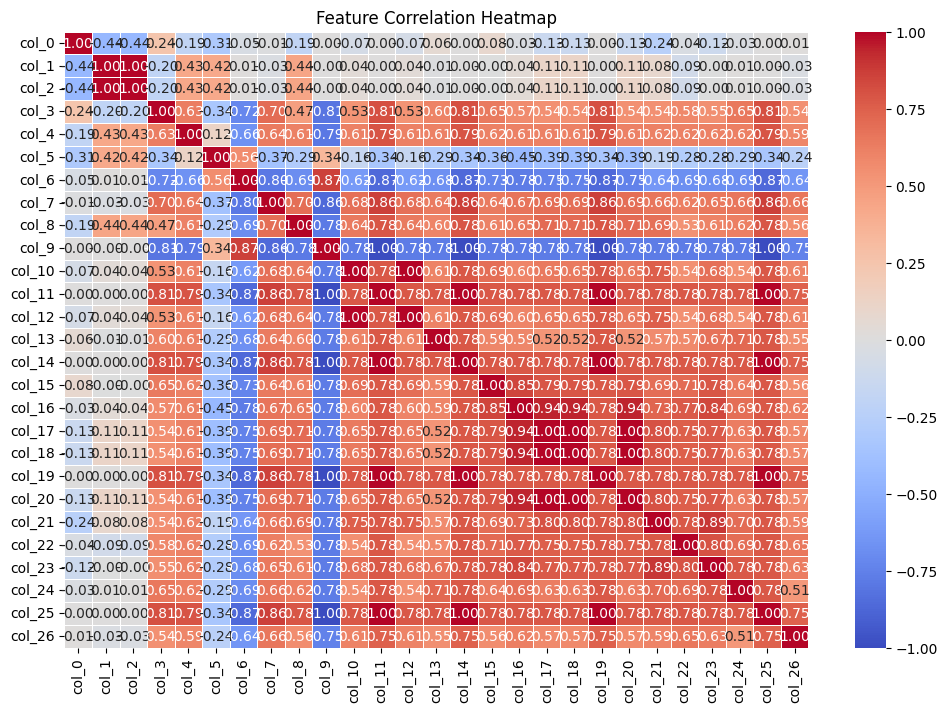

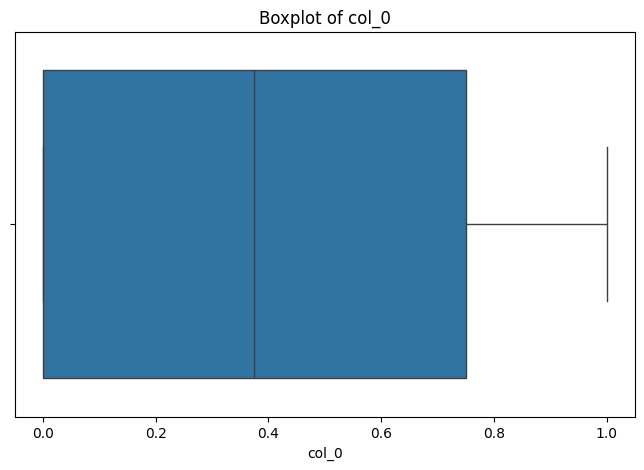

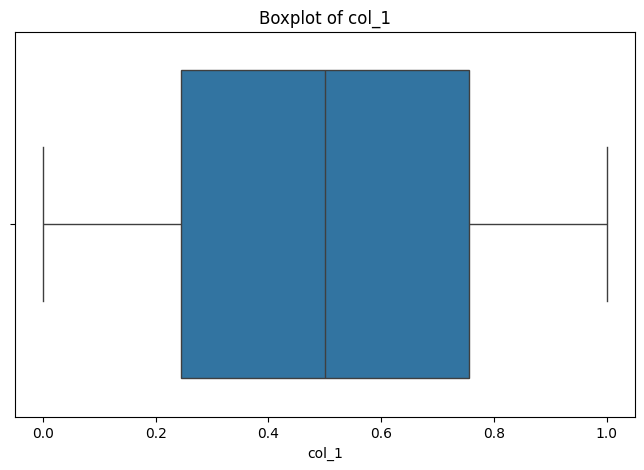

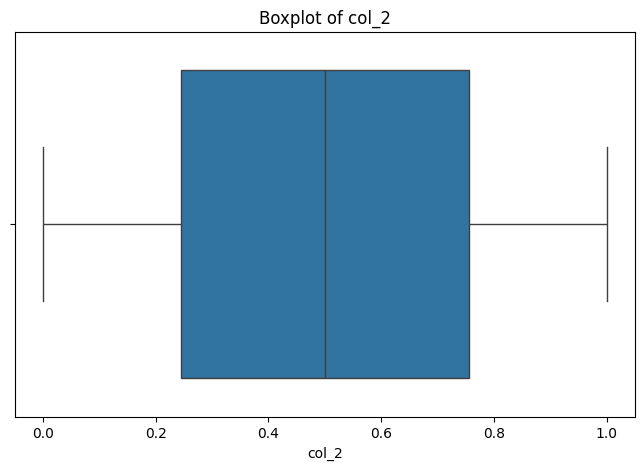

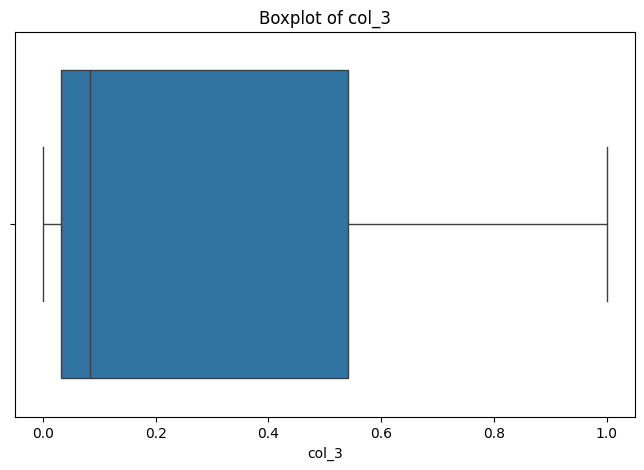

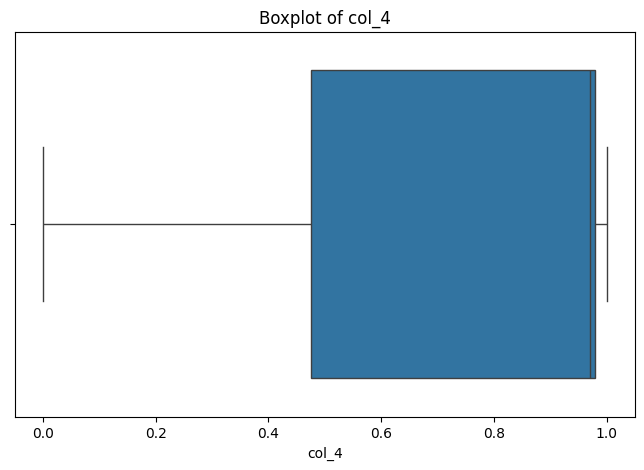

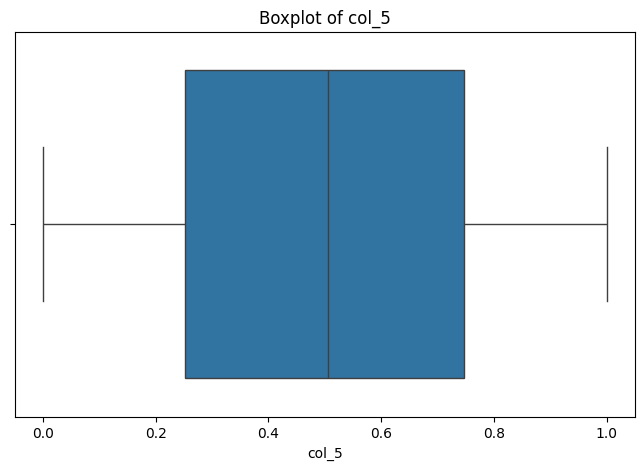

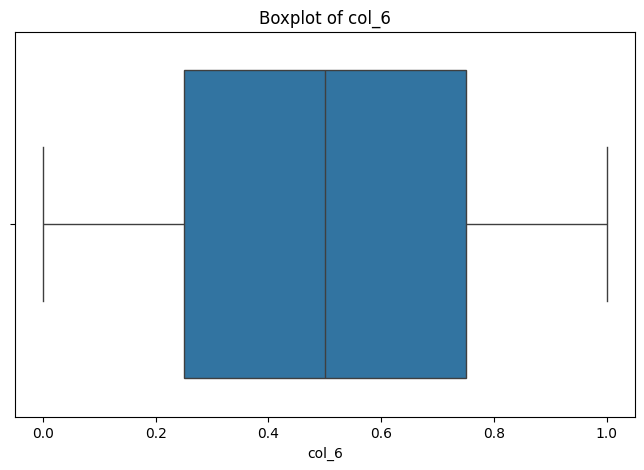

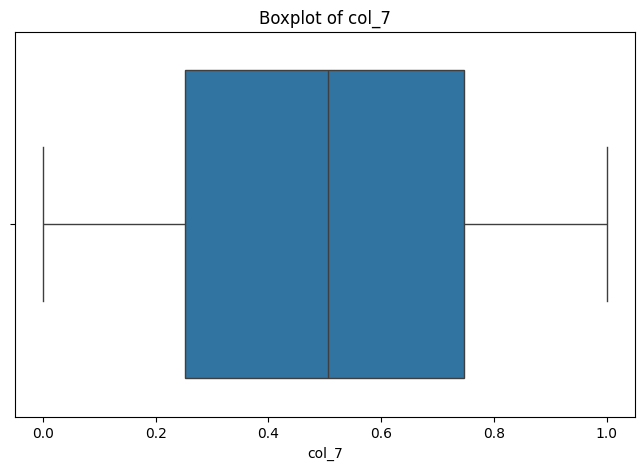

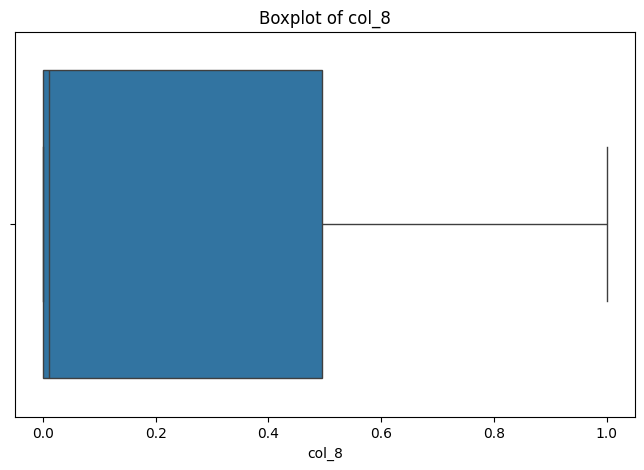

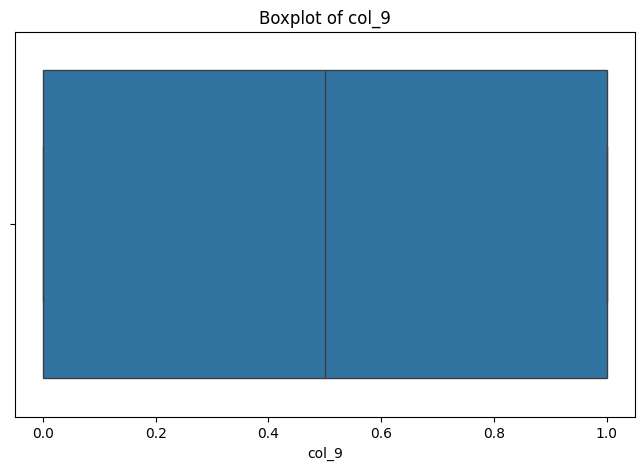

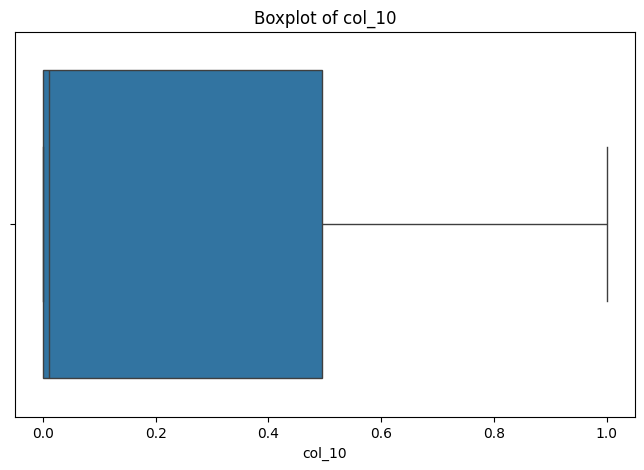

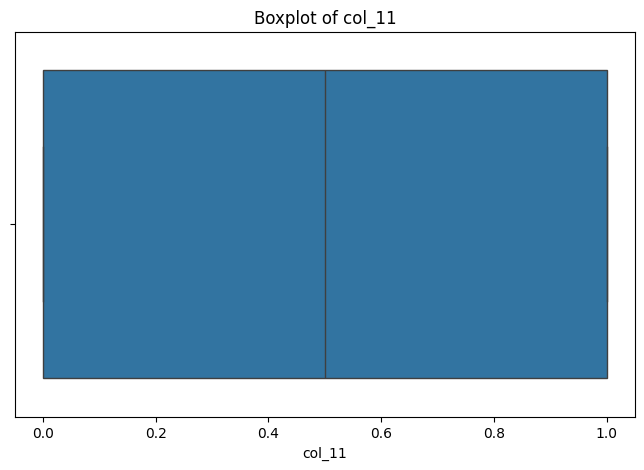

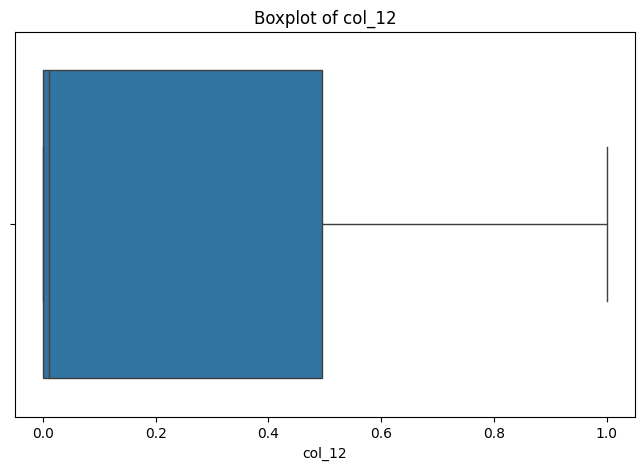

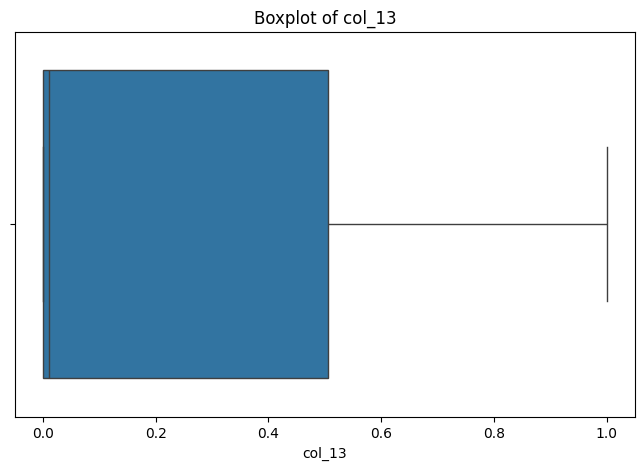

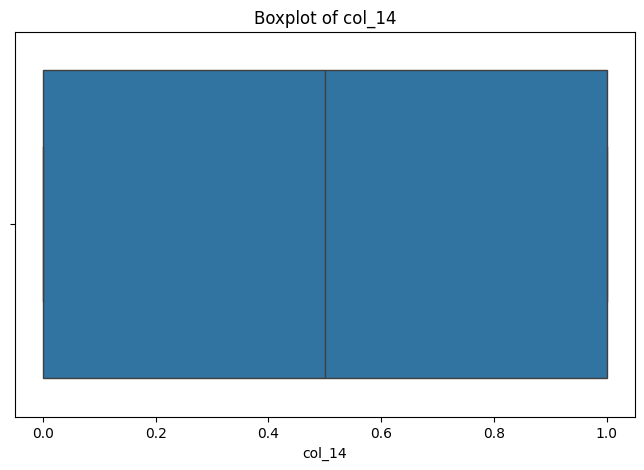

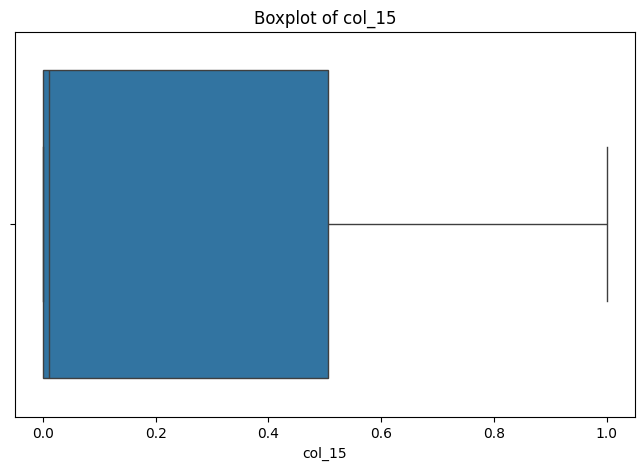

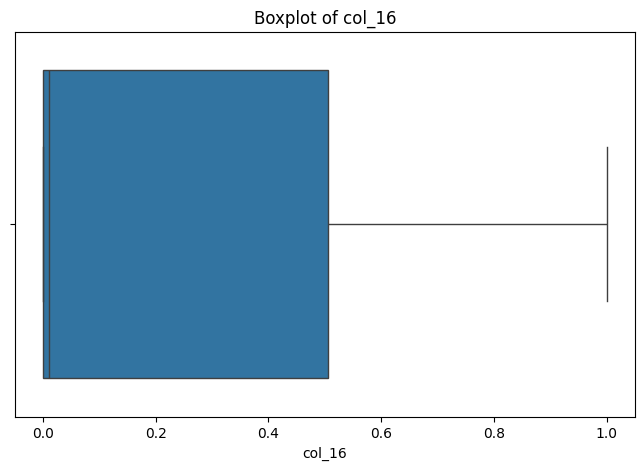

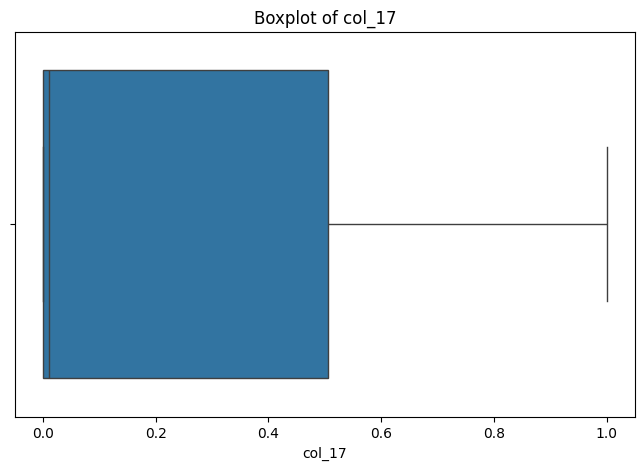

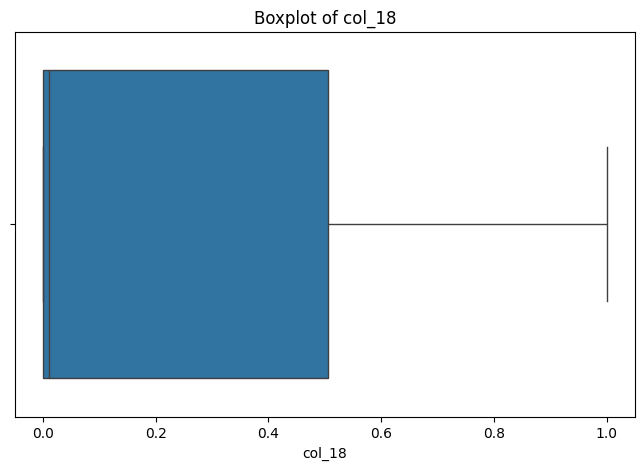

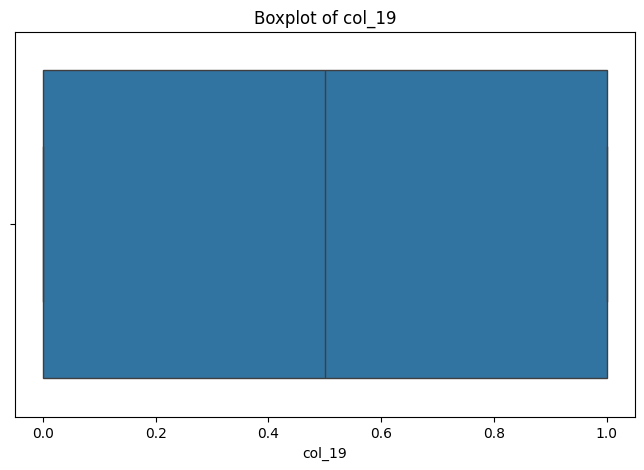

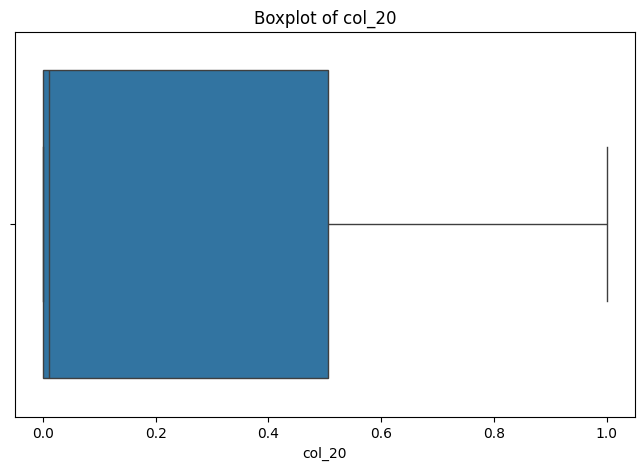

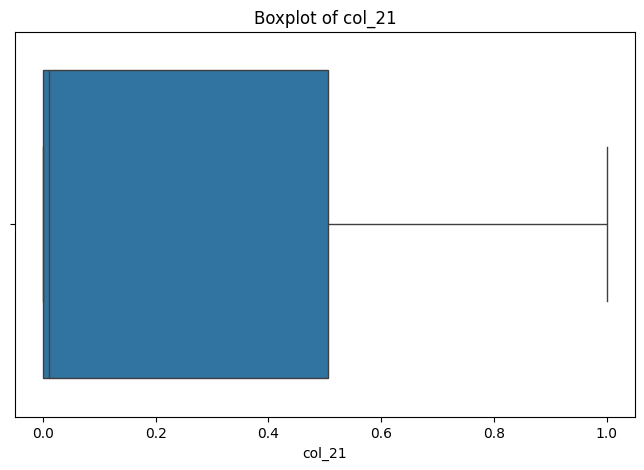

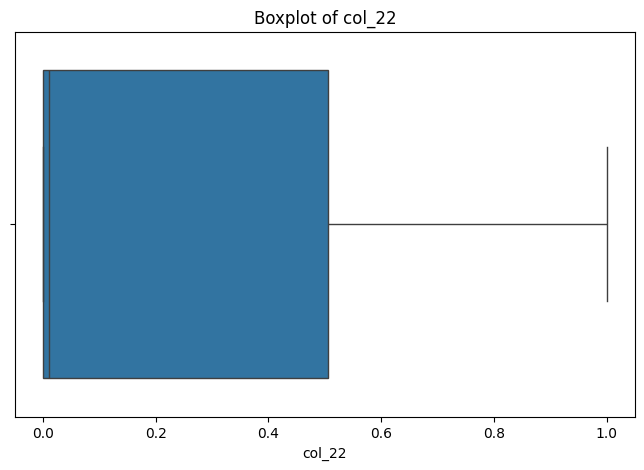

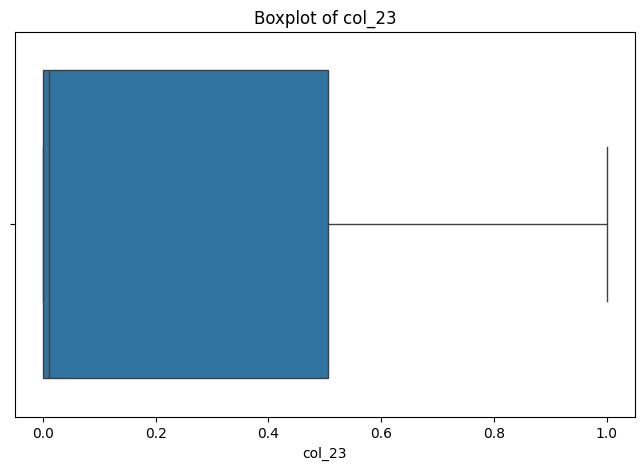

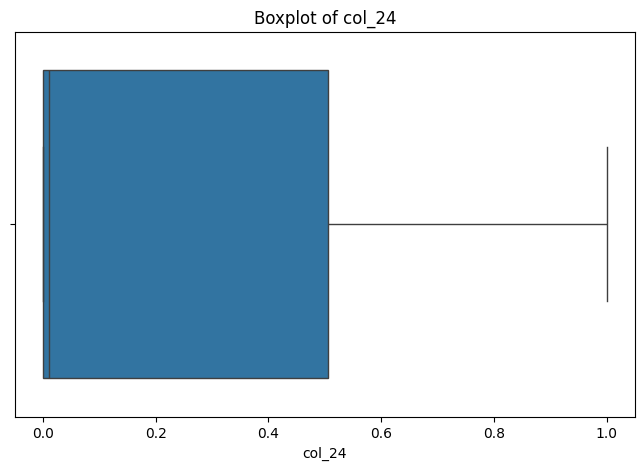

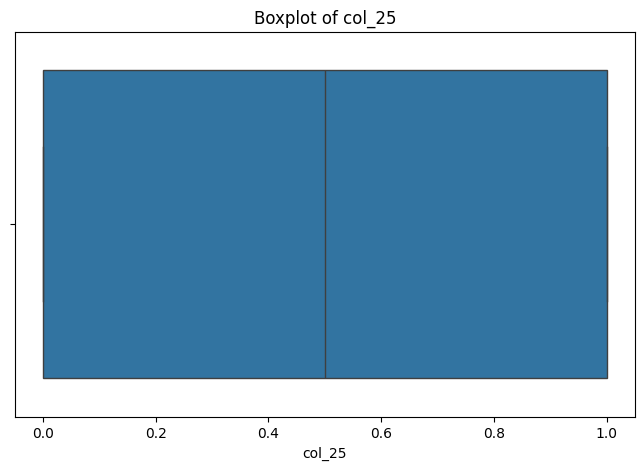

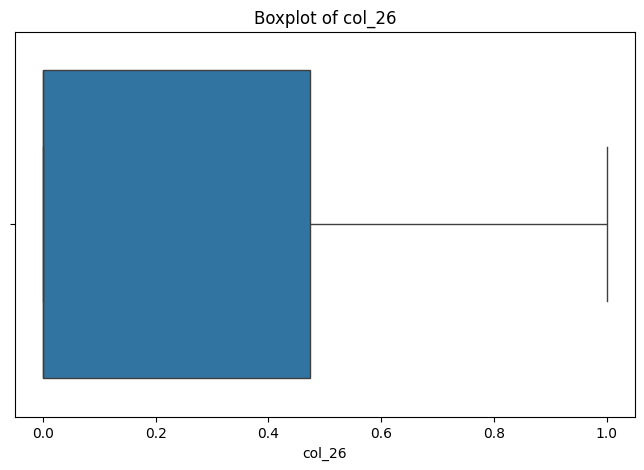

In [25]:
# EDA - Now on final_testing_set

# Step 1: Dataset Preview
print("Dataset Preview:")
print(final_testing_set.head())

# Step 2: General Information
print("\nDataset Info:")
final_testing_set.info()

# Step 3: Checking for Missing Values
print("\nMissing Values per Column:")
print(final_testing_set.isnull().sum())

# Step 4: Summary Statistics
print("\nSummary Statistics:")
print(final_testing_set.describe())

# Step 5: Checking Feature Distributions
for col in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(final_testing_set[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Step 6: Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(final_testing_set.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Step 7: Detecting Outliers using Boxplots
for col in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=final_testing_set[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Step 8: Checking Class Balance (for classification tasks)
if 'target' in final_testing_set.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=final_testing_set['target'])
    plt.title("Class Distribution")
    plt.show()

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Ensure column names are clean and standardized (if not done previously)
final_testing_set.columns = [str(col).strip().lower().replace(" ", "_") for col in final_testing_set.columns]

# Step 1: Handling Categorical Features (Label Encoding)
categorical_columns = final_testing_set.select_dtypes(exclude=['number']).columns.tolist()

# Label Encoding for categorical columns (if any)
if categorical_columns:
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        final_testing_set[col] = le.fit_transform(final_testing_set[col].astype(str))
        label_encoders[col] = le  # Store encoders for later use

# Step 2: Feature Creation (New Features)
# Example 1: Create a new feature based on existing ones
if 'date_column' in final_testing_set.columns:
    # Assuming you have a column 'date_column' with datetime values
    final_testing_set['year'] = pd.to_datetime(final_testing_set['date_column']).dt.year
    final_testing_set['month'] = pd.to_datetime(final_testing_set['date_column']).dt.month
    final_testing_set['day'] = pd.to_datetime(final_testing_set['date_column']).dt.day
    final_testing_set['weekday'] = pd.to_datetime(final_testing_set['date_column']).dt.weekday

# Example 2: Creating a new feature by combining two features
if 'feature1' in final_testing_set.columns and 'feature2' in final_testing_set.columns:
    final_testing_set['combined_feature'] = final_testing_set['feature1'] * final_testing_set['feature2']

# Example 3: Binning numeric data (if appropriate)
if 'numeric_column' in final_testing_set.columns:
    bins = [0, 50, 100, 150]  # Example bin edges
    labels = ['Low', 'Medium', 'High']  # Labels for bins
    final_testing_set['numeric_binned'] = pd.cut(final_testing_set['numeric_column'], bins=bins, labels=labels)

# Step 3: Feature Scaling (Normalization/Standardization)
# Normalizing numerical features using MinMaxScaler
numerical_columns = final_testing_set.select_dtypes(include=['number']).columns.tolist()

scaler = MinMaxScaler()
final_testing_set[numerical_columns] = scaler.fit_transform(final_testing_set[numerical_columns])

# Step 4: Handling Missing Values (if any remain after preprocessing)
final_testing_set = final_testing_set.fillna(final_testing_set.mean())  # You can use other strategies based on your needs

# Step 5: Dropping Unnecessary Features
# Drop columns that are not useful for modeling
final_testing_set = final_testing_set.drop(['column_to_drop'], axis=1, errors='ignore')

# Step 6: Final Feature Check
print("Processed Data Preview After Feature Engineering:")
print(final_testing_set.head())

# Optionally, you can check the data types of columns after the transformations
print("\nData Types After Feature Engineering:")
print(final_testing_set.dtypes)


Processed Data Preview After Feature Engineering:
    col_0     col_1     col_2     col_3  col_4     col_5     col_6     col_7  \
83   0.25  0.428571  0.428571  0.018519   0.40  0.551020  0.555556  0.428571   
53   0.00  0.959184  0.959184  0.000000   0.92  0.979592  0.909091  0.122449   
70   1.00  0.020408  0.020408  0.074074   0.02  0.183673  0.525253  0.377551   
45   0.50  0.000000  0.000000  0.814815   1.00  0.122449  0.121212  0.653061   
44   1.00  0.530612  0.530612  1.000000   1.00  0.061224  0.060606  0.591837   

       col_8  col_9  ...  col_17  col_18  col_19  col_20  col_21  col_22  \
83  0.000000    1.0  ...     0.0     0.0     0.0     0.0    0.00     0.0   
53  0.000000    1.0  ...     0.0     0.0     0.0     0.0    0.00     0.0   
70  0.000000    1.0  ...     0.0     0.0     0.0     0.0    0.00     0.0   
45  0.020408    0.0  ...     1.0     1.0     1.0     1.0    0.94     1.0   
44  0.530612    0.0  ...     0.4     0.4     1.0     0.4    0.04     0.1   

    col_23  

In [52]:
from sklearn.model_selection import train_test_split

# Assign different names to each column
final_testing_set.columns = [f'feature_{i}' for i in range(final_testing_set.shape[1])]

# Loop through each column as a target variable
for target_column in final_testing_set.columns:
    # Define the target column
    y = final_testing_set[target_column]
    
    # Features (exclude the target column in each loop)
    X = final_testing_set.drop(columns=[target_column])  # Features
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Print the shapes of the training and testing sets
    print(f"Target: {target_column}")
    print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
    print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")
    print("="*50)


Target: feature_0
Training set shape: X_train=(80, 26), y_train=(80,)
Testing set shape: X_test=(20, 26), y_test=(20,)
Target: feature_1
Training set shape: X_train=(80, 26), y_train=(80,)
Testing set shape: X_test=(20, 26), y_test=(20,)
Target: feature_2
Training set shape: X_train=(80, 26), y_train=(80,)
Testing set shape: X_test=(20, 26), y_test=(20,)
Target: feature_3
Training set shape: X_train=(80, 26), y_train=(80,)
Testing set shape: X_test=(20, 26), y_test=(20,)
Target: feature_4
Training set shape: X_train=(80, 26), y_train=(80,)
Testing set shape: X_test=(20, 26), y_test=(20,)
Target: feature_5
Training set shape: X_train=(80, 26), y_train=(80,)
Testing set shape: X_test=(20, 26), y_test=(20,)
Target: feature_6
Training set shape: X_train=(80, 26), y_train=(80,)
Testing set shape: X_test=(20, 26), y_test=(20,)
Target: feature_7
Training set shape: X_train=(80, 26), y_train=(80,)
Testing set shape: X_test=(20, 26), y_test=(20,)
Target: feature_8
Training set shape: X_train=(8

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Assuming `final_testing_set` is your dataframe

# Loop through each target column
for target_column in final_testing_set.columns:
    print(f"Training and evaluating for target: {target_column}")
    
    # Features (X) and target (y)
    y = final_testing_set[target_column]
    X = final_testing_set.drop(columns=[target_column])  # Exclude the target column from the features

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature Scaling (standardization for neural networks)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Build the Neural Network model
    model = Sequential()

    # Input layer: number of neurons should match the number of features
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

    # Hidden layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    # Output layer: for regression tasks, use 'linear' activation
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model using Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    
    # Print evaluation results
    print(f"Mean Squared Error for target '{target_column}': {mse:.4f}")
    print("="*50)


Training and evaluating for target: feature_0
Epoch 1/100


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1632  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0745 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0671
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0478
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0566 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0610
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0357
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0460
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0408
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0314
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0321
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0400 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0352
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0383
Epoch 16/10

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3709  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1107
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0237
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0154
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010    
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1165e-04
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8689e-04
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9135e-04
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7120e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4608e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2022  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0365
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0229
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7082e-04
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2708e-04
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3796e-04
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5320e-04
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5296e-04
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7233e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3913e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2602  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0457
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0243
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0234
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0159
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4078e-04 
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015
Epoch 16/

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1537  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014    
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6075e-04
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8652e-04 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7391e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1495  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0515
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0225
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0280
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0134
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020    
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012    
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6553e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6679e-04 
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.38

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7357  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0704
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0368
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0111
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0083
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0063
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0117
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0074
Epoch 16/100


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1967  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1047 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0392 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0294
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0148
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0112
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0117
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0120 
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0110
Epoch 16/

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3781  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1031 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0586 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0239 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0143
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0091 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.9859e-04
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3231e-04 
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7841e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0132e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4786  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0458
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0326 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7498e-04 
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8804e-04
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8367e-04 
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9453e-04 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1310e-04
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1251e-04 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0181e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2413  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0395
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0074
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013    
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3291e-04
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8755e-04
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7938e-04
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5494e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3255e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4841  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0566
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0377
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014    
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2513e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014
Epoch 

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1534  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0303
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0224 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9495e-04 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7535e-04 
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4589e-04
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6922e-04
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2583e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2176e-05
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1889  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0550
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0325
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0178 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0140 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0099
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066     
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038 
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038     
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019     
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss:

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4947  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0805
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0300
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0230
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015     
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8624e-04 
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0287e

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1164  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0363 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0252
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0106
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0094
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042    
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016    
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9279e-04
E

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4008  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0867
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0313
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020     
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4393e-04
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0962e-04 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2270e-04 
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1995e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3448e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6899  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1027
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0386
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0261
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0074 
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3574e-04
Epoch 

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0648  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014    
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4169e-04
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2451e-04
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3327e-04
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4037e-04
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5759e-04
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3428e-05
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1152e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2451  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0619
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0101
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014    
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8160e-04
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9550e-04
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8682e-04
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0480e-04 
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1109e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0558e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2123  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0243 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014    
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5906e-04
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3751e-04
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8483e-04
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9433e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5175e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6315  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0722
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0367
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0409
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0230
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0100
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0065
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029
Epoch 16/100
1

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1515  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0410 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0371
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0242
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0159
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024    
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017    
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016    
E

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1286  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0348
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0291 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0158
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0046
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4082e-04 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0103e-04
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9112e-04
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8668e-04
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9453e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8956e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - l

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1227  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0688
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0499
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0388
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0199
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0083
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0084
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022    
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 
Epoch 

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6566  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0740
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0266
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0177
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027     
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023     
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016    
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013     
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013    
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1108  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0747 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0306
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0285
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0201
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0044
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012    
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012    
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013
Epoch

Evaluating performance for target: feature_0


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


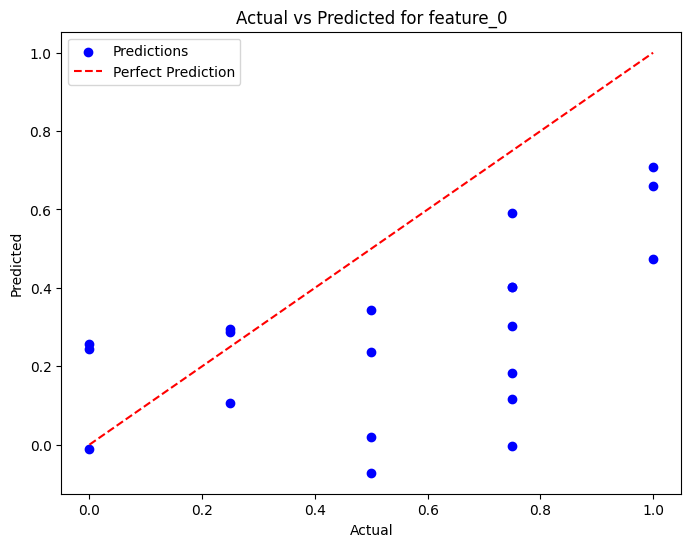

Mean Squared Error for target 'feature_0': 0.1520
Evaluating performance for target: feature_1


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


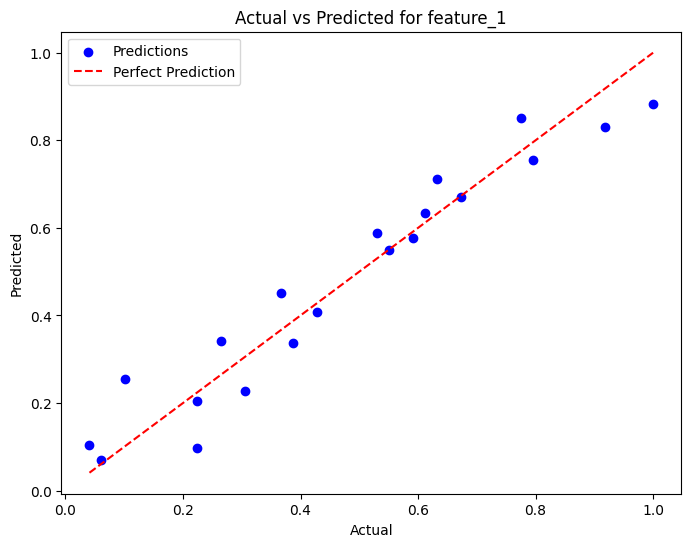

Mean Squared Error for target 'feature_1': 0.0052
Evaluating performance for target: feature_2


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


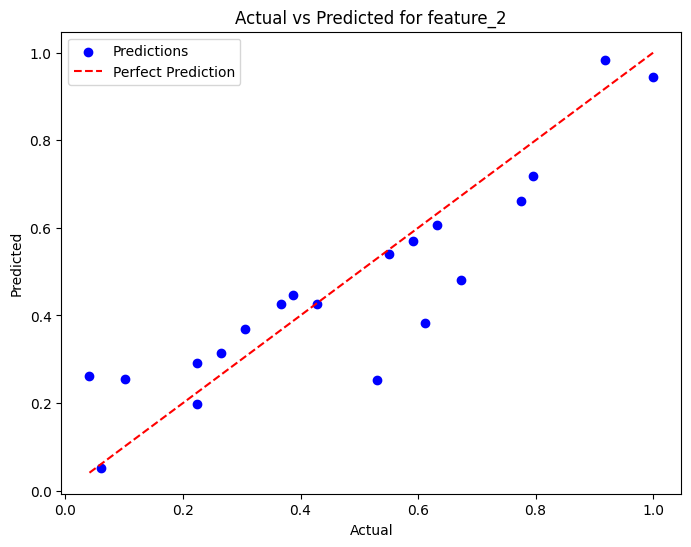

Mean Squared Error for target 'feature_2': 0.0143
Evaluating performance for target: feature_3


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


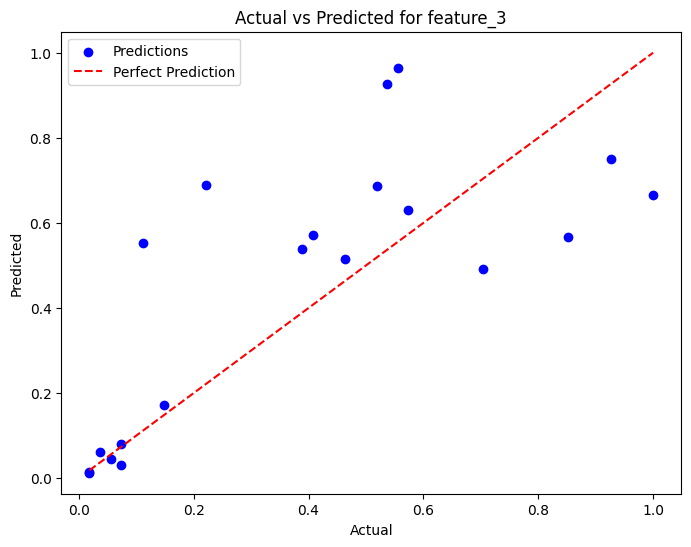

Mean Squared Error for target 'feature_3': 0.0544
Evaluating performance for target: feature_4


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


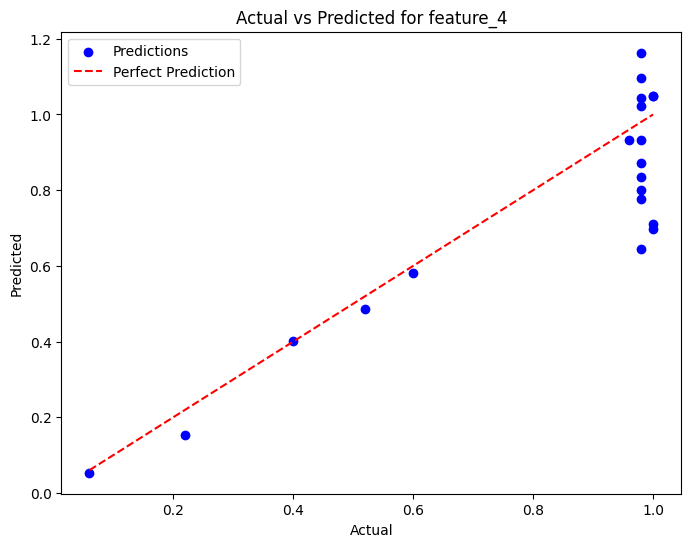

Mean Squared Error for target 'feature_4': 0.0230
Evaluating performance for target: feature_5


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


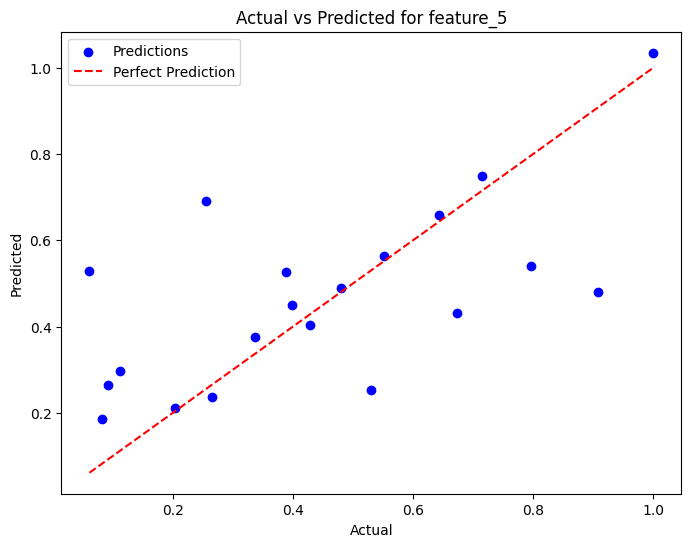

Mean Squared Error for target 'feature_5': 0.0449
Evaluating performance for target: feature_6


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


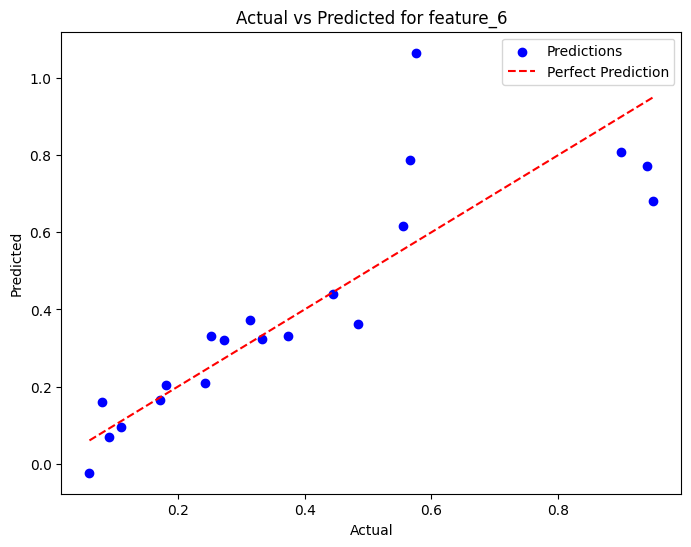

Mean Squared Error for target 'feature_6': 0.0223
Evaluating performance for target: feature_7


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


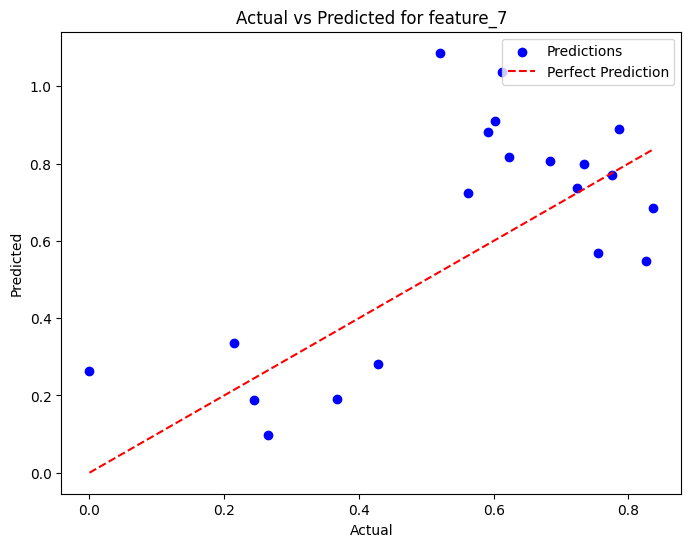

Mean Squared Error for target 'feature_7': 0.0539
Evaluating performance for target: feature_8


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


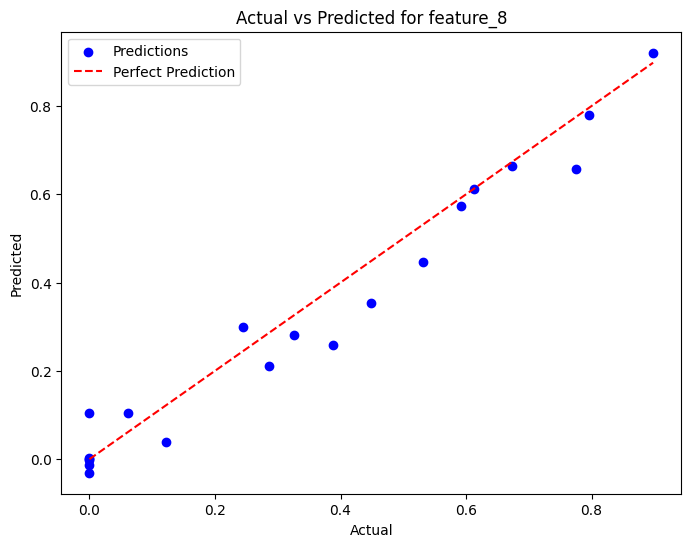

Mean Squared Error for target 'feature_8': 0.0039
Evaluating performance for target: feature_9


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


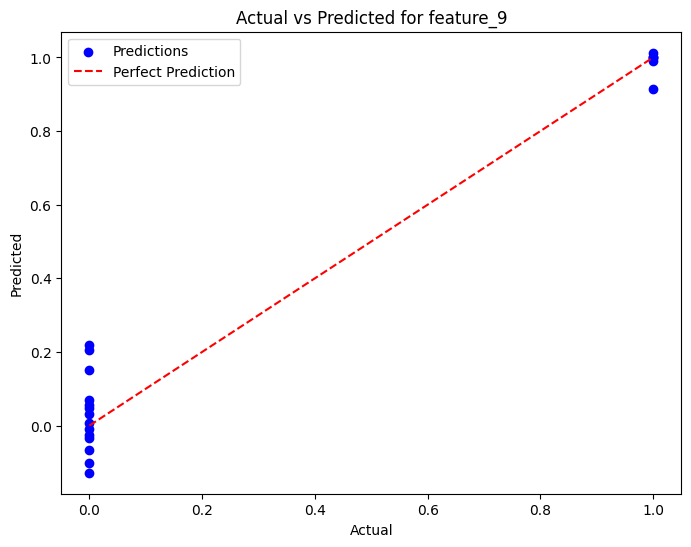

Mean Squared Error for target 'feature_9': 0.0082
Evaluating performance for target: feature_10


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


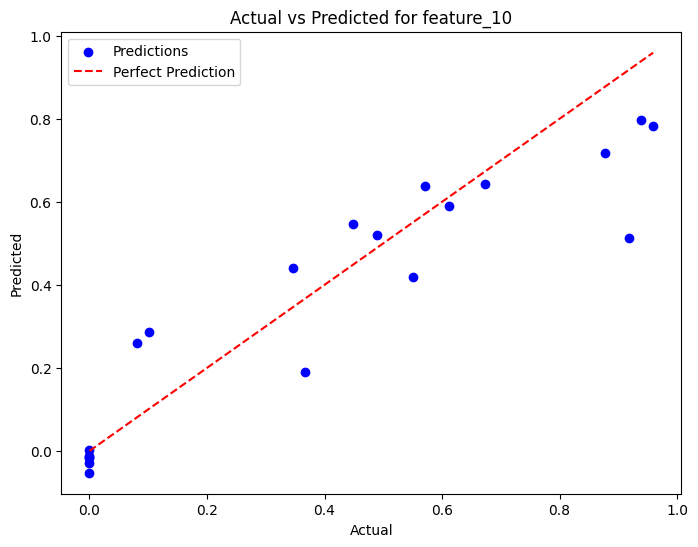

Mean Squared Error for target 'feature_10': 0.0193
Evaluating performance for target: feature_11


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


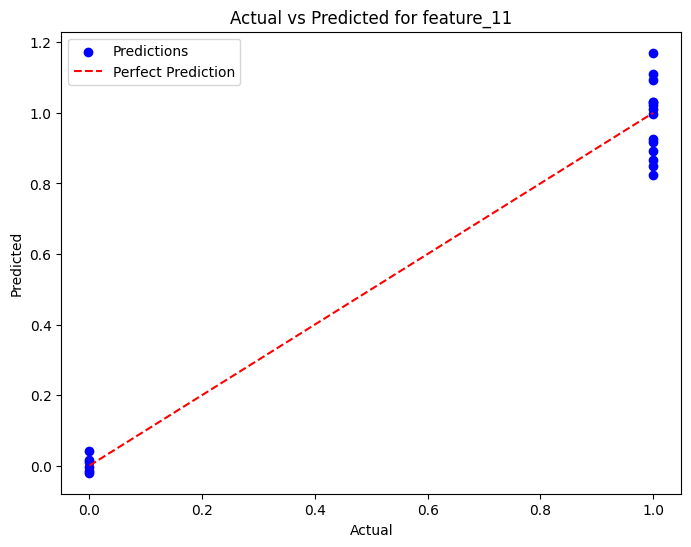

Mean Squared Error for target 'feature_11': 0.0076
Evaluating performance for target: feature_12


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


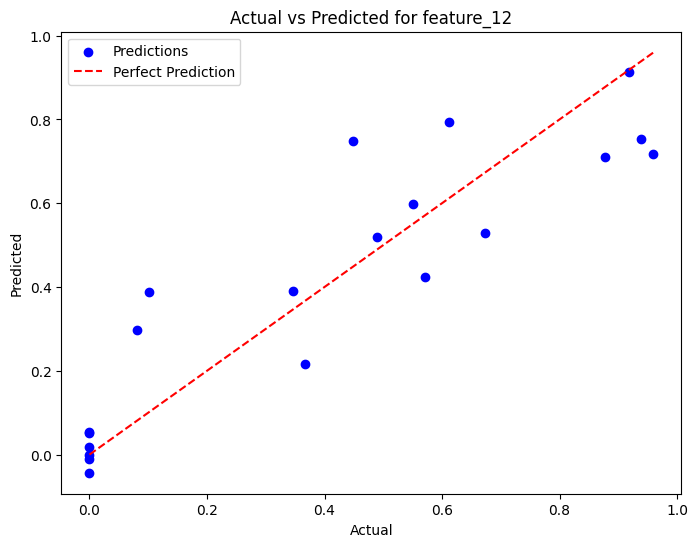

Mean Squared Error for target 'feature_12': 0.0225
Evaluating performance for target: feature_13


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


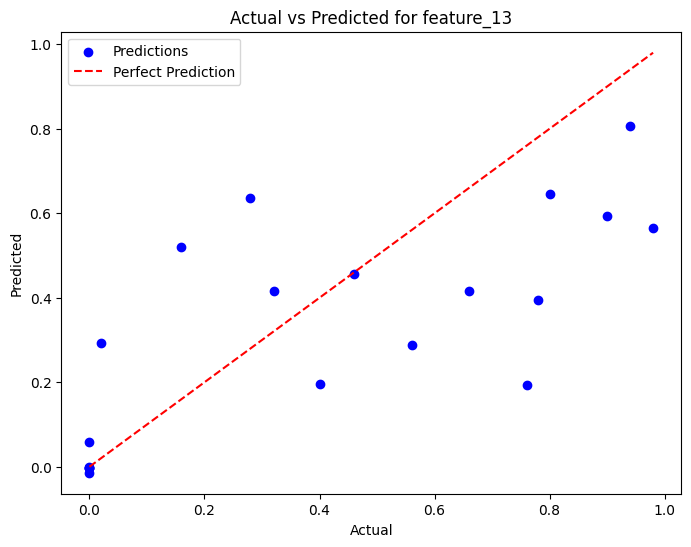

Mean Squared Error for target 'feature_13': 0.0649
Evaluating performance for target: feature_14


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


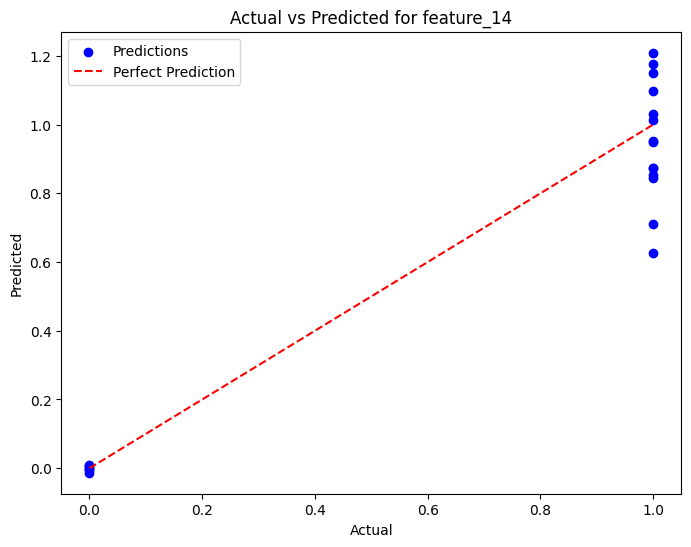

Mean Squared Error for target 'feature_14': 0.0208
Evaluating performance for target: feature_15


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


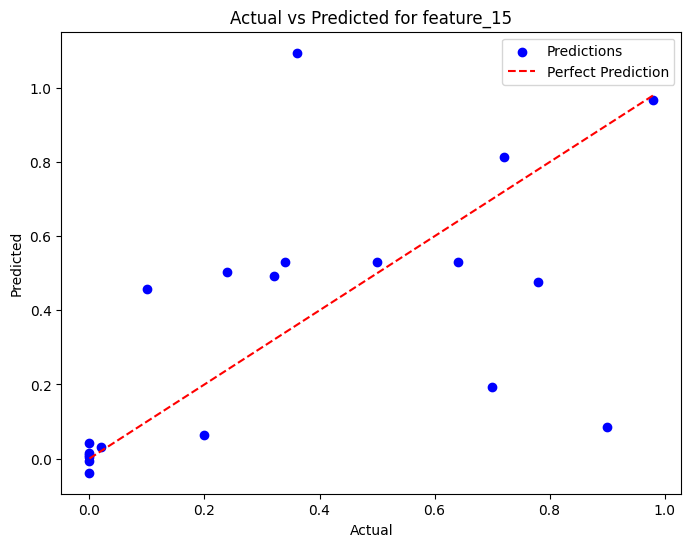

Mean Squared Error for target 'feature_15': 0.0930
Evaluating performance for target: feature_16


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


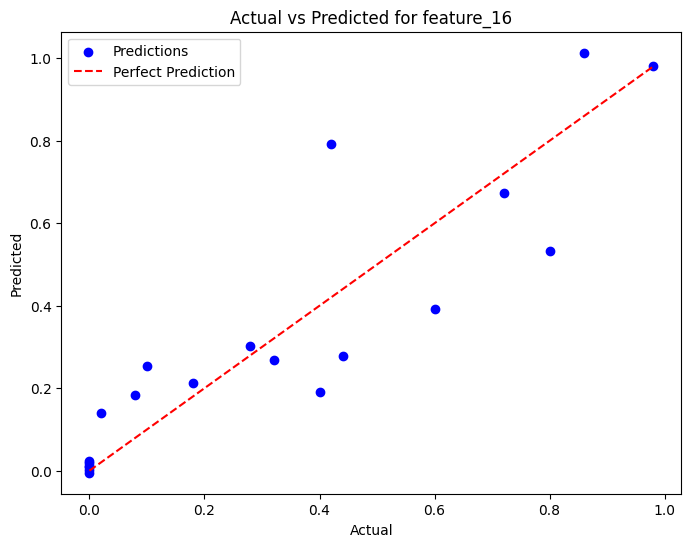

Mean Squared Error for target 'feature_16': 0.0201
Evaluating performance for target: feature_17


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


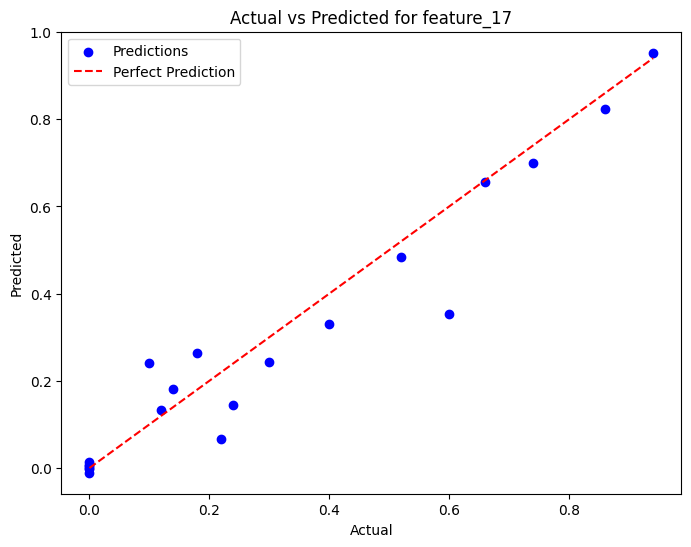

Mean Squared Error for target 'feature_17': 0.0068
Evaluating performance for target: feature_18


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


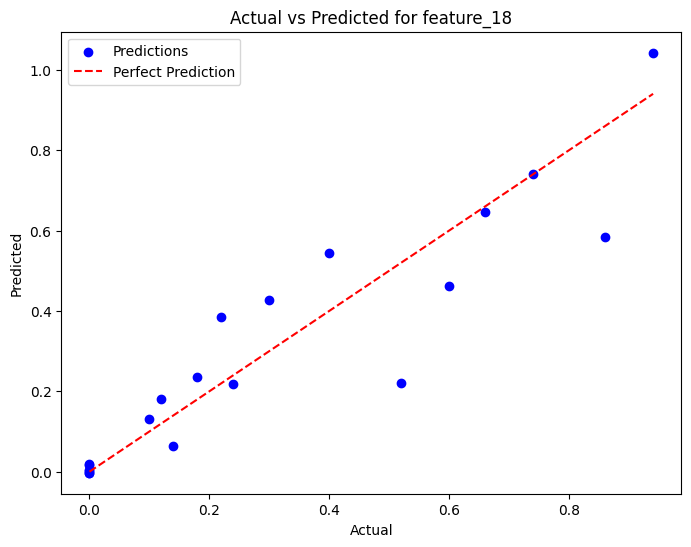

Mean Squared Error for target 'feature_18': 0.0137
Evaluating performance for target: feature_19


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


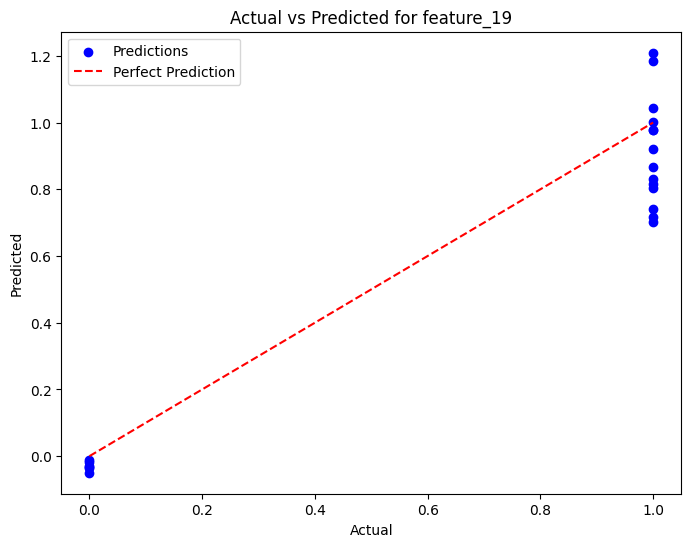

Mean Squared Error for target 'feature_19': 0.0224
Evaluating performance for target: feature_20


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


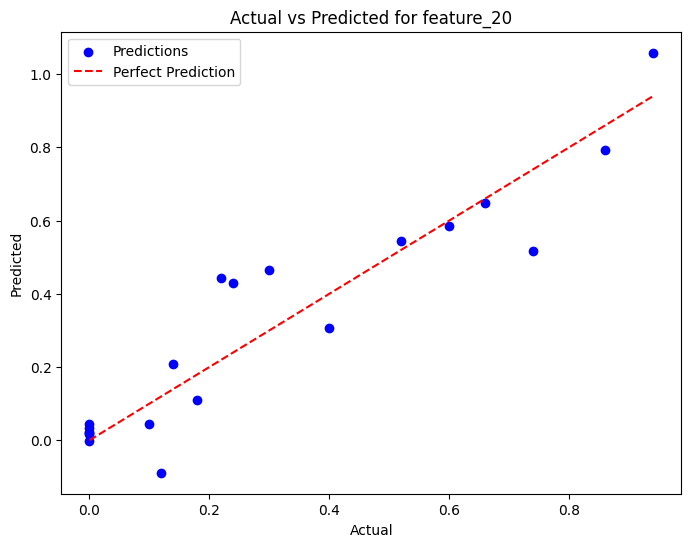

Mean Squared Error for target 'feature_20': 0.0126
Evaluating performance for target: feature_21


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


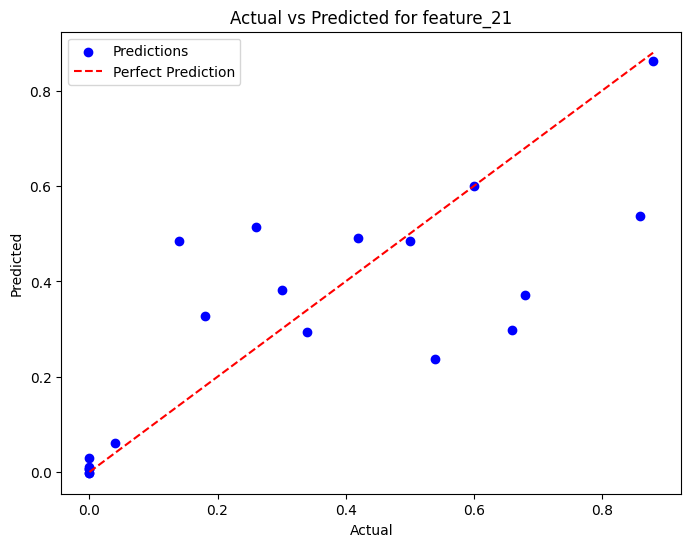

Mean Squared Error for target 'feature_21': 0.0322
Evaluating performance for target: feature_22


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


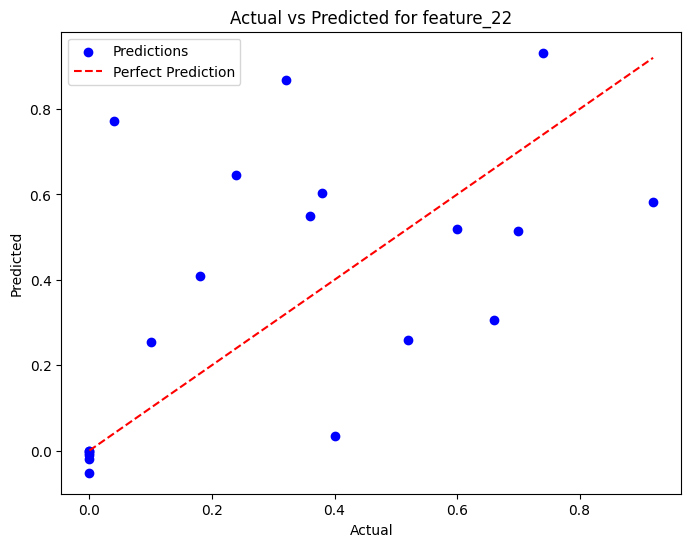

Mean Squared Error for target 'feature_22': 0.0841
Evaluating performance for target: feature_23


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


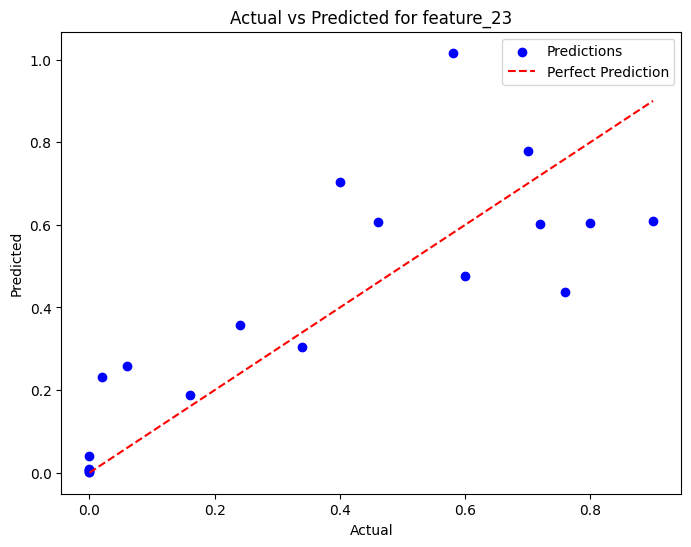

Mean Squared Error for target 'feature_23': 0.0333
Evaluating performance for target: feature_24


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


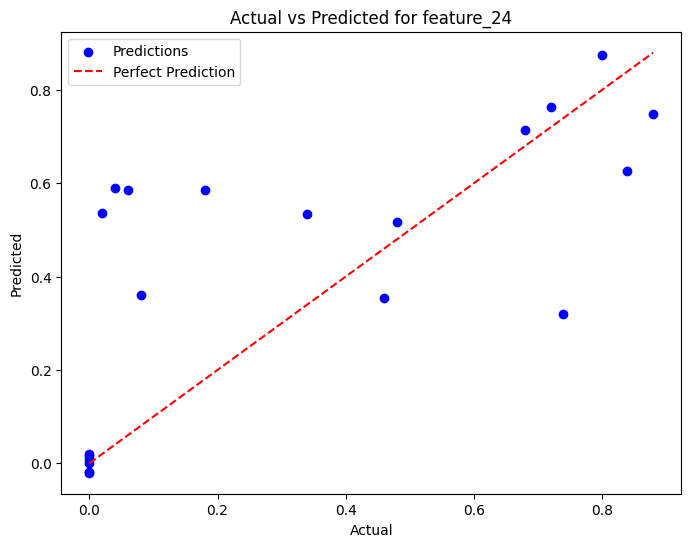

Mean Squared Error for target 'feature_24': 0.0695
Evaluating performance for target: feature_25


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


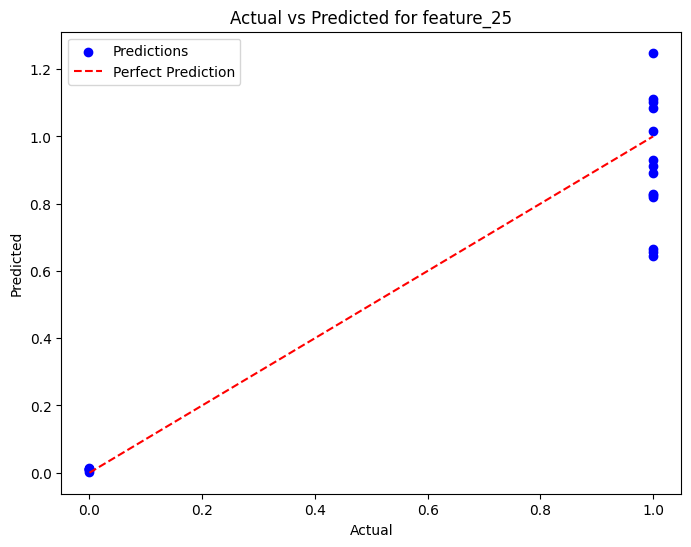

Mean Squared Error for target 'feature_25': 0.0283
Evaluating performance for target: feature_26


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


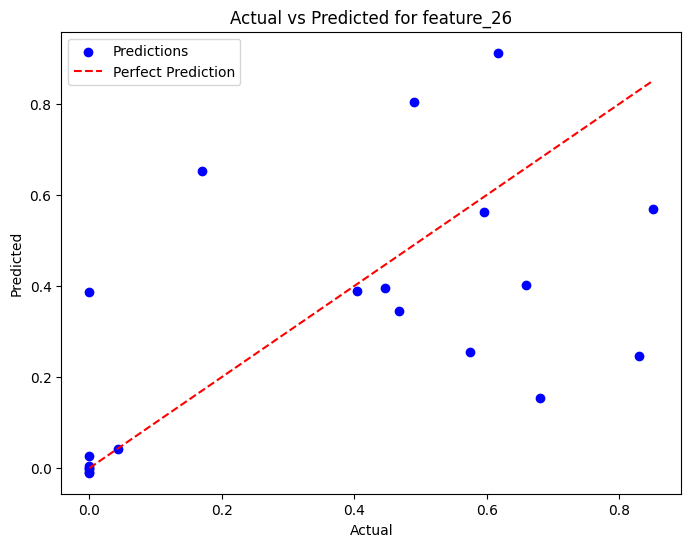

Mean Squared Error for target 'feature_26': 0.0727


In [58]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Loop through each target column in the final_testing_set
for target_column in final_testing_set.columns:
    print(f"Evaluating performance for target: {target_column}")
    
    # Features (X) and target (y)
    y = final_testing_set[target_column]
    X = final_testing_set.drop(columns=[target_column])  # Exclude the target column from the features

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature Scaling (standardization for neural networks)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Build the Neural Network model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Output layer for regression task

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)  # Train quietly without verbosity

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Plot Actual vs Predicted for each feature
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, color='blue', label='Predictions')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f"Actual vs Predicted for {target_column}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()
    plt.show()

    # Calculate and display Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error for target '{target_column}': {mse:.4f}")
    print("="*50)


In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming final_testing_set is your dataframe
# Loop through each target column
for target_column in final_testing_set.columns:
    print(f"Training and evaluating for target: {target_column}")
    
    # Features (X) and target (y)
    y = final_testing_set[target_column]
    X = final_testing_set.drop(columns=[target_column])  # Exclude the target column from the features

    # Feature Scaling (standardization for neural networks)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # K-Fold Cross Validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    mse_scores = []

    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build the Neural Network model
        model = Sequential()
        model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='linear'))  # Output layer for regression task
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model
        model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)  # Set verbose=0 to suppress logs

        # Predict and calculate Mean Squared Error (MSE)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

    # Average MSE across all folds
    avg_mse = np.mean(mse_scores)
    print(f"Average Mean Squared Error for target '{target_column}' across all folds: {avg_mse:.4f}")
    print("="*50)


Training and evaluating for target: feature_0


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Average Mean Squared Error for target 'feature_0' across all folds: 0.1738
Training and evaluating for target: feature_1


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Average Mean Squared Error for target 'feature_1' across all folds: 0.1150
Training and evaluating for target: feature_2


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Average Mean Squared Error for target 'feature_2' across all folds: 0.1270
Training and evaluating for target: feature_3


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Average Mean Squared Error for target 'feature_3' across all folds: 0.1880
Training and evaluating for target: feature_4


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Average Mean Squared Error for target 'feature_4' across all folds: 0.1806
Training and evaluating for target: feature_5


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Average Mean Squared Error for target 'feature_5' across all folds: 0.1553
Training and evaluating for target: feature_6


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Average Mean Squared Error for target 'feature_6' across all folds: 0.1557
Training and evaluating for target: feature_7


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Average Mean Squared Error for target 'feature_7' across all folds: 0.1460
Training and evaluating for target: feature_8


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Average Mean Squared Error for target 'feature_8' across all folds: 0.1425
Training and evaluating for target: feature_9


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Average Mean Squared Error for target 'feature_9' across all folds: 0.4414
Training and evaluating for target: feature_10


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Average Mean Squared Error for target 'feature_10' across all folds: 0.2175
Training and evaluating for target: feature_11


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Average Mean Squared Error for target 'feature_11' across all folds: 0.4611
Training and evaluating for target: feature_12


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Average Mean Squared Error for target 'feature_12' across all folds: 0.2265
Training and evaluating for target: feature_13


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Average Mean Squared Error for target 'feature_13' across all folds: 0.1886
Training and evaluating for target: feature_14


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Average Mean Squared Error for target 'feature_14' across all folds: 0.4658
Training and evaluating for target: feature_15


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Average Mean Squared Error for target 'feature_15' across all folds: 0.1689
Training and evaluating for target: feature_16


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Average Mean Squared Error for target 'feature_16' across all folds: 0.2047
Training and evaluating for target: feature_17


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Average Mean Squared Error for target 'feature_17' across all folds: 0.1869
Training and evaluating for target: feature_18


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Average Mean Squared Error for target 'feature_18' across all folds: 0.1975
Training and evaluating for target: feature_19


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Average Mean Squared Error for target 'feature_19' across all folds: 0.4900
Training and evaluating for target: feature_20


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Average Mean Squared Error for target 'feature_20' across all folds: 0.1775
Training and evaluating for target: feature_21


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Average Mean Squared Error for target 'feature_21' across all folds: 0.2112
Training and evaluating for target: feature_22


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Average Mean Squared Error for target 'feature_22' across all folds: 0.1983
Training and evaluating for target: feature_23


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Average Mean Squared Error for target 'feature_23' across all folds: 0.2086
Training and evaluating for target: feature_24


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Average Mean Squared Error for target 'feature_24' across all folds: 0.2178
Training and evaluating for target: feature_25


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Average Mean Squared Error for target 'feature_25' across all folds: 0.4142
Training and evaluating for target: feature_26


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Average Mean Squared Error for target 'feature_26' across all folds: 0.1870
